In [71]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle


import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [72]:
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_90k_tns_df.csv', index_col='ztf_object_id')
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_90-10.csv.gz', compression='gzip', index_col='ztf_object_id')
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_85-15.csv.gz', compression='gzip', index_col='ztf_object_id')
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_80-20.csv.gz', compression='gzip', index_col='ztf_object_id')
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_80-20_v2.csv.gz', compression='gzip', index_col='ztf_object_id')

#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_80-20_addJiterNorm0p1.csv.gz', compression='gzip', index_col='ztf_object_id')
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_80-20_addJiterNorm0p05.csv.gz', compression='gzip', index_col='ztf_object_id')
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_80-20_addJiterNorm0p02.csv.gz', compression='gzip', index_col='ztf_object_id')
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_80-20_addJiterNorm0p01.csv.gz', compression='gzip', index_col='ztf_object_id')



#smote_suffix = 'SMOTE_train_test_80-20_min8_kneighbors5'
smote_suffix = 'SMOTE_train_test_80-20_min8_kneighbors5_addJitterNorm0p01' # 
#smote_suffix = 'SMOTE_train_test_80-20_min8_kneighbors5_addJitterNorm0p02' # adding jitter makes everything rec a None or Ia (maybe only jitter minority classes? -- too hard)
dataset_bank_tns_df = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_{smote_suffix}.csv.gz', compression='gzip', index_col='ztf_object_id')


dataset_bank_tns_df

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21achsafa,0.428150,0.322517,0.363636,0.045455,0.332956,0.856300,0.565358,0.340263,-0.511557,-0.000879,...,0.292000,0.430201,0.343700,0.301701,6.463402,0.166869,Yes_TNS,None,-99.000000,ZTF
ZTF21aapllew,0.456563,0.344524,0.272727,0.000000,0.424843,0.913126,0.779600,0.544160,-1.345365,0.030332,...,0.753700,0.650600,0.839100,0.566301,3.807968,0.467874,Yes_TNS,None,-99.000000,ALeRCE
ZTF20acpgnsn,0.644044,0.359593,0.300000,0.100000,0.351365,1.288088,1.049413,0.285427,1.028901,0.024707,...,1.432600,1.416500,1.768200,1.622400,276.665348,0.743416,Yes_TNS,SN Ia,0.036258,GaiaAlerts
ZTF21abcjacg,0.211900,0.184602,0.250000,0.000000,0.363585,0.423800,0.423800,0.232222,2.953315,0.046716,...,0.396500,0.393600,0.330200,0.386301,39.837244,0.117561,Yes_TNS,None,-99.000000,ALeRCE
ZTF21acjelll,0.203988,0.330260,0.200000,0.000000,0.332901,0.407976,0.407976,0.163809,2.729947,-0.032997,...,0.036499,0.153299,0.023701,-0.107000,5.568779,1.281861,Yes_TNS,None,-99.000000,ALeRCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20aciymmp,0.341483,0.506777,0.384615,0.038462,0.360703,0.680812,0.527380,0.212717,-0.197511,-0.001048,...,0.248699,0.268700,0.265600,0.014200,101.440543,0.022850,No_TNS,None,-99.000000,None
ZTF20acwcfvx,0.717740,0.456017,0.380952,0.000000,0.424108,1.435480,1.263850,0.828254,-1.230210,0.033134,...,1.866700,1.806400,1.663099,1.577801,43.047509,1.235676,Yes_TNS,SN Ia,0.077000,ALeRCE
ZTF18adarvpj,0.192029,0.293309,0.400000,0.000000,0.306827,0.384058,0.384058,0.117165,2.031387,0.005793,...,-0.056000,-0.060999,-0.023701,-0.160000,5.375503,1.237219,Yes_TNS,None,-99.000000,ZTF


In [73]:
suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{smote_suffix}"

### Both noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p008_SMOTE_80-20 and noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20 are good (hostdownweighted maybe sliiightly better)

### suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p2_SMOTE_80-20" is nearly if not as good as hostdownweighted


In [74]:
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_sep_highlighted_SMOTE_90-10" # could be ok
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_sep_highlighted_SMOTE_80-20"


#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_direct_output_SMOTE_90-10" # not great
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_direct_output_SMOTE_80-20"


#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE_90-10" # decent
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE_80-20" # eh
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE_80-20" # second best to hostdownweighted



#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_90-10" # decent but hard to say
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_85-15" # decent; better than 90-10
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #The best i think

#suffix="noTNScut_pca5_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #not good. more degenerate with only 5pcs. 65% var
#suffix="noTNScut_pca10_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #not bad. 80% var
#suffix="noTNScut_pca15_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #decent. 86% var
#suffix="noTNScut_pca25_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #p close to noPCA but slightly worse (less self reference classes)
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #really good, better than 25pca
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #really v good[!] better than 35pca (best PC implementation)
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_euclidean" # decent but not as good as manhattan distance (above)

# same PCs but different scalers and/or metrics
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #really v good, better than 35pca (best PC implementation)
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # decent but not amazing. 99% var
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_euclidean" # awful (similarity match). AD is ok... 99% var

#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_hamming" #not that good.
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_angular" #decent. Worth trying with other scalers.
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_dot" #SS not good. always matches to None lol.


# manhattan
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #really v good[!] better than 35pca (best PC implementation)
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # decent but not amazing. 99% var
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MinMax_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # great Sim Search. less great AD (but ok)
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # Best one! great Sim Search. great AD[!] might be best one!
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_RobustS-25-75_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # fine, but not as good as MaxAbs or SS

# euclidean
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_euclidean" # decent but not as good as manhattan distance (above)
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_euclidean" # awful (similarity match). AD is ok... 99% var
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MinMax_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_euclidean" # decent Sim Search. decent AD but others are better
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_euclidean" # pretty bad
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_RobustS-25-75_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_euclidean" #decent but others are better


# angular
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_angular" #decent. Worth trying with other scalers.
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_angular" #ok but not great.
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MinMax_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_angular" #eh Sim Search. Good AD[!]
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_angular" #eh Sim Search. bad AD.
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_RobustS-25-75_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_angular" #eh Sim Search. awful AD 


# BEST AD OPTIONS for PCA
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # Best one! great Sim Search. great AD[!] might be best one!
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #really v good[!] better than 35pca (best PC implementation)
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MinMax_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_angular" #eh Sim Search. Good AD[!]

# trying
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p1" # too big. need smaller jitter. 98% var
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p05" # too big. need smaller jitter. 98% var. 
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p02" # 95% var. PC plots look good. Not great but jitter spread is more realistic
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p01" # 95% var. PC plots look better. Not great but jitter is more realistic

#suffix="noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE_80-20" # amazing sim search. 99%var. AD is quite good, maybe 2nd or 3rd best. Maybe overall best when considering both!
#suffix="noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE_80-20_v2" # same as above but with fixed alerce class return


# best in AD going down in PCs
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # Best one! great Sim Search. great AD[!] might be best one! 99% var
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # !! Really nice. Same/better results with less PCs. 98% var.
#suffix="noTNScut_pca25_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # Not bad but losing steam from higher PCs. 97% var
#suffix="noTNScut_pca15_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # about as good as 25 PCs. 93% var
#suffix="noTNScut_pca10_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # Not bad but losing steam from higher PCs. 87% var
#suffix="noTNScut_pca5_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # 71% var. really falls off

#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_NOfw_SMOTE_80-20" # decent but maybe not the best
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_direct_output_SMOTE_80-20" # ok but not amazing
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_host2p0_SMOTE_80-20" # decent. but galaxies basically play no factor
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_host0p2_SMOTE_80-20" # eh sim search. not awful AD
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_host0p008_SMOTE_80-20" # awful sim search. bad


#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p008_SMOTE_90-10" # eh
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p008_SMOTE_85-15" # better than hostdownweighted 85-15
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p008_SMOTE_80-20" # good. slightly worse than hostdownweighted_SMOTE_80-20
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p008_SMOTE_80-20" # not as good as hostdownweighted


#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p2_SMOTE_80-20" # 
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p2_SMOTE_80-20" # decent, but hostdownweighted is the best







#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_SMOTE_90-10"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_SMOTE_85-15" # tied second best
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_SMOTE_80-20" # tied second best



#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_SMOTE"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_direct_output_SMOTE"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_sep_highlighted_SMOTE"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_sep_highlighted_SMOTE"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_sep_highlighted"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_LConly"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_noSS_AlerceCls_fw_MI_classif_LConly"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_noSS_AlerceCls_fw_MI_classif_only2"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after_MI_classif_only"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after_MI_classif_highlight_sepFs"
#suffix=f"noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after_fromDict"

ann_num = 350
col_list= [f'dist={col}' for col in range(1, ann_num)]
dist_col = f'Max-{len(col_list)}ANNs'


ann_dist_all_df = pd.read_csv(f'../loci_dbs/alerce_cut/ann_dist_all_df_{suffix}_ann_num={ann_num}.csv', index_col=0)
ann_dist_all_df.index = ann_dist_all_df.index.rename('ztf_object_id')
ann_dist_all_df

,Mean-349ANNs,Max-349ANNs
ztf_object_id,,
ZTF17aadqidc,36.643935,39.568138
ZTF18aaavffc,61.428552,64.946190
ZTF18aacnlxz,39.709457,42.271538
ZTF18aacoqhv,47.654117,50.035362
ZTF18aagazmu,48.978133,51.991138
...,...,...
ZTF22aaayewi,53.964783,56.754662
ZTF22aaayghd,44.717737,48.094757
ZTF22aaayghr,49.879462,52.536160


In [75]:
merge_df = pd.concat([ann_dist_all_df, dataset_bank_tns_df], axis=1)
merge_df = merge_df[~merge_df.isnull().any(axis=1)]
merge_df

,Mean-349ANNs,Max-349ANNs,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF17aadqidc,36.643935,39.568138,0.118791,0.276625,0.428571,0.000,0.385504,0.237581,0.223594,0.138365,...,0.163198,0.160099,0.150101,0.122200,26.155457,0.051662,No_TNS,None,-99.000000,None
ZTF18aaavffc,61.428552,64.946190,1.251362,2.169584,0.291667,0.025,0.338697,2.387948,2.022931,0.747013,...,0.625299,0.541301,0.607000,0.500100,87.296246,0.003534,Yes_TNS,None,-99.000000,ALeRCE
ZTF18aacnlxz,39.709457,42.271538,0.301177,0.305369,0.400000,0.000,0.394944,0.602354,0.524916,0.248890,...,0.000801,-0.006701,-0.005301,0.105499,140.931455,0.172488,Yes_TNS,SN II,0.072475,ZTF
ZTF18aacoqhv,47.654117,50.035362,0.122245,0.185015,0.400000,0.000,0.359752,0.244490,0.244490,0.127299,...,0.831900,0.825801,0.759799,0.681800,44.172885,0.101415,Yes_TNS,None,-99.000000,ATLAS
ZTF18aagazmu,48.978133,51.991138,0.137987,0.478688,0.285714,0.000,0.355481,0.275974,0.242938,0.086162,...,0.837799,0.842300,0.816299,0.931400,78.554061,0.228036,Yes_TNS,None,-99.000000,ALeRCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF22aaayewi,53.964783,56.754662,0.468829,0.274049,0.428571,0.000,0.416170,0.937658,0.902286,0.675280,...,1.552100,1.500700,1.667700,1.523500,264.886837,0.622978,Yes_TNS,SN Ia,0.024981,ASAS-SN
ZTF22aaayghd,44.717737,48.094757,0.149980,0.445525,0.166667,0.000,0.442115,0.299959,0.292818,0.228550,...,0.801100,0.855902,0.736500,0.646000,23.516153,0.300569,Yes_TNS,None,-99.000000,ATLAS
ZTF22aaayghr,49.879462,52.536160,0.181614,0.180604,0.250000,0.000,0.362783,0.363228,0.363228,0.211961,...,0.986900,1.140900,0.952301,0.825399,82.969849,1.323984,Yes_TNS,SN Ia,0.060000,ZTF


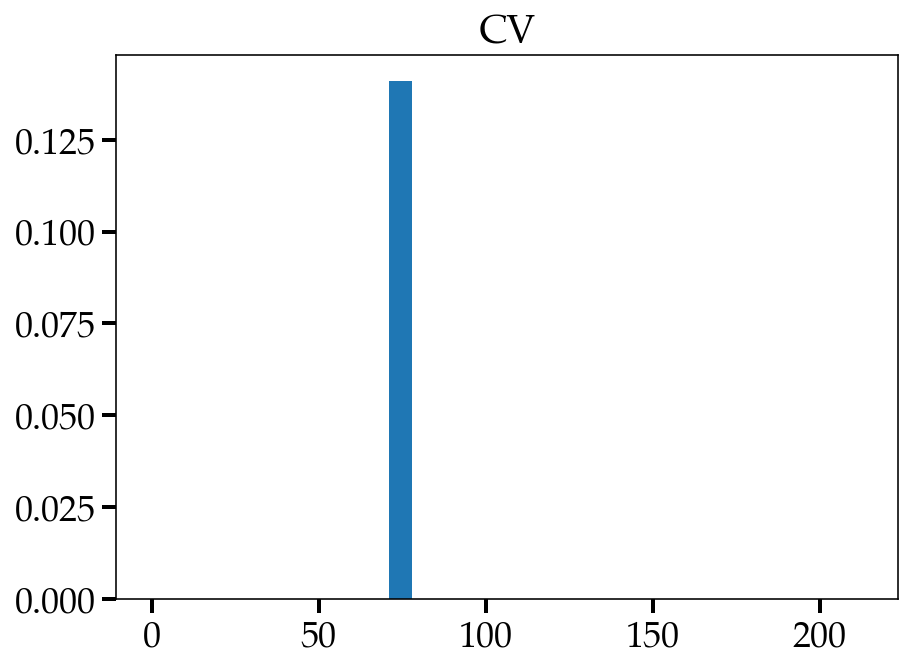

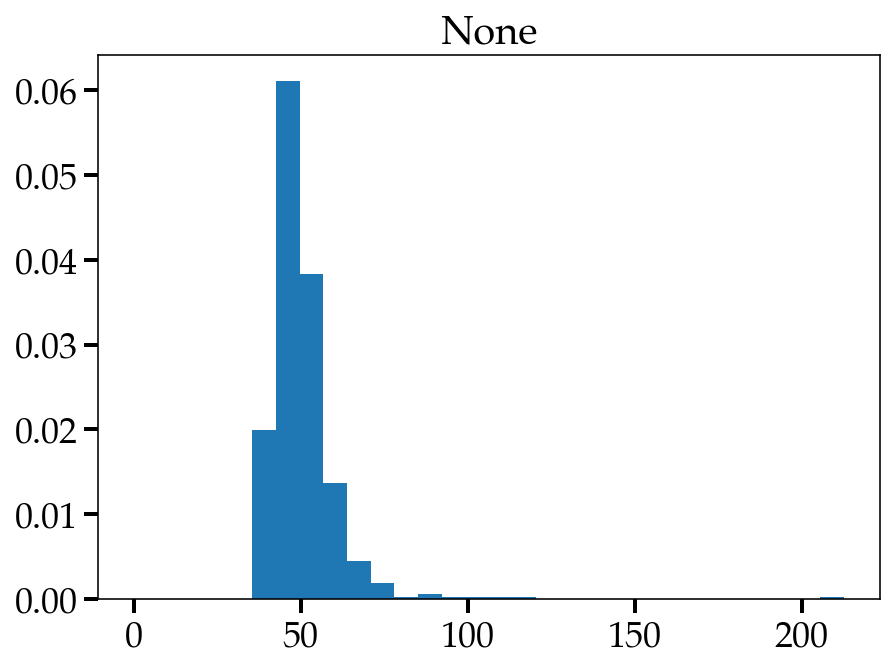

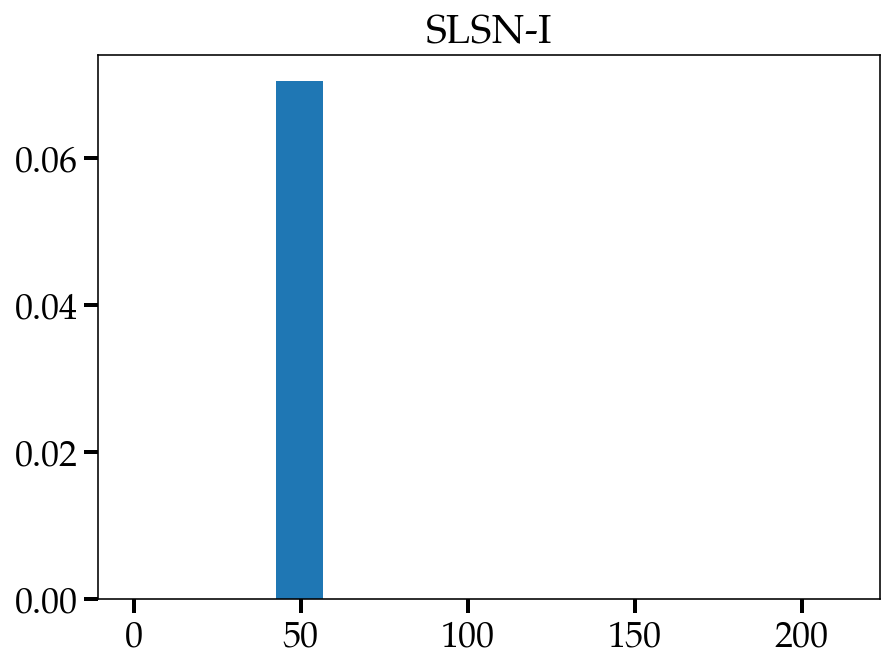

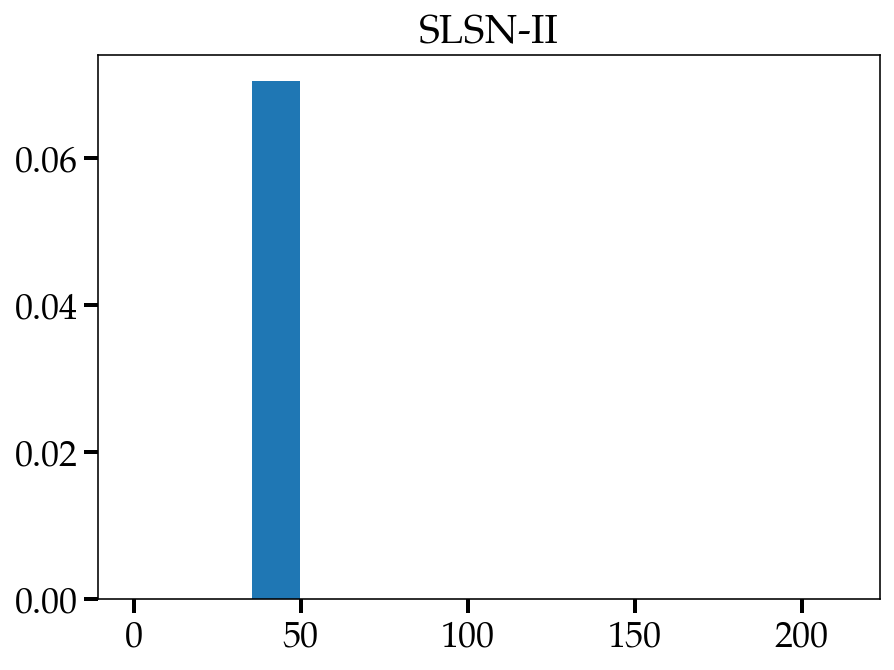

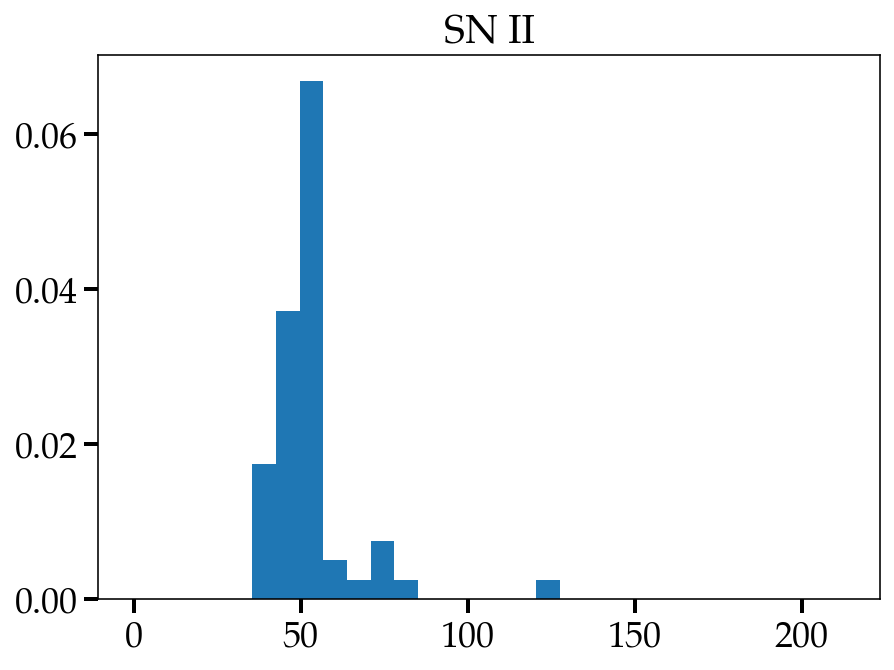

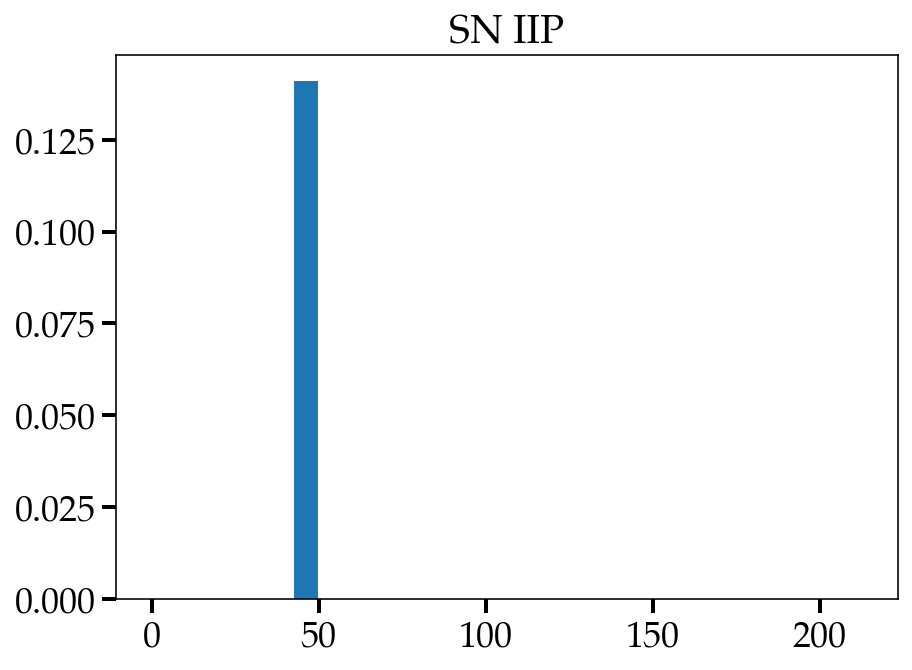

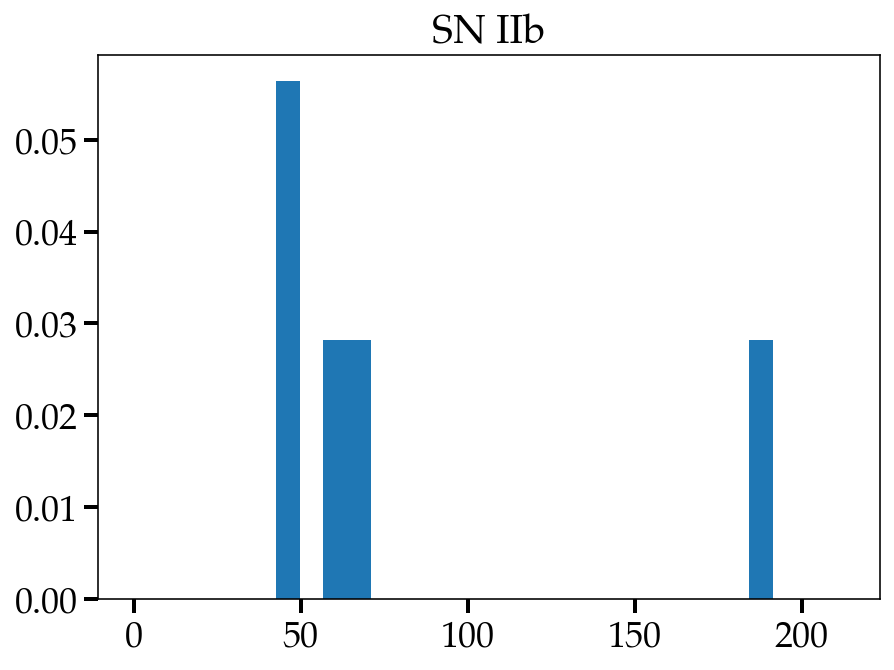

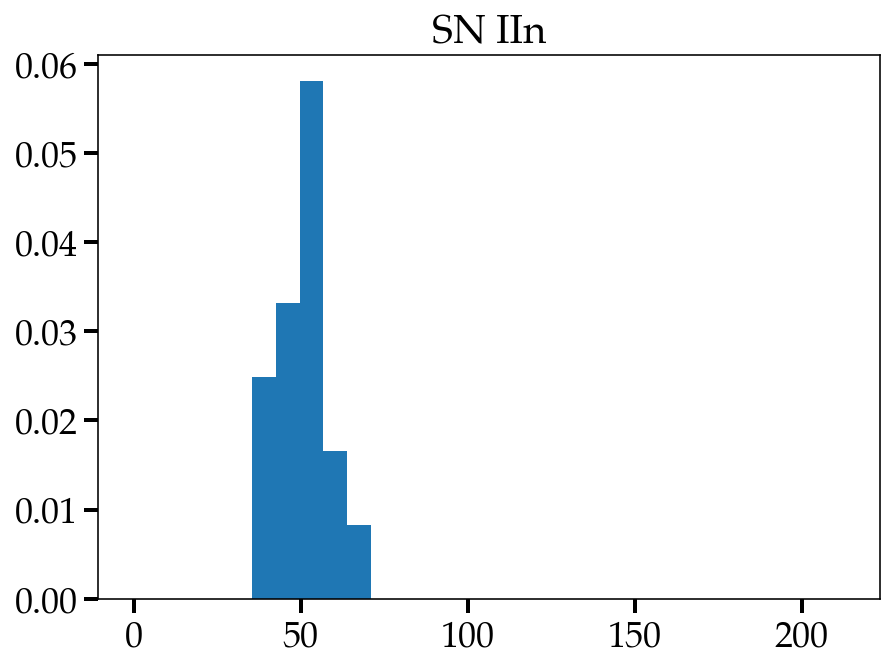

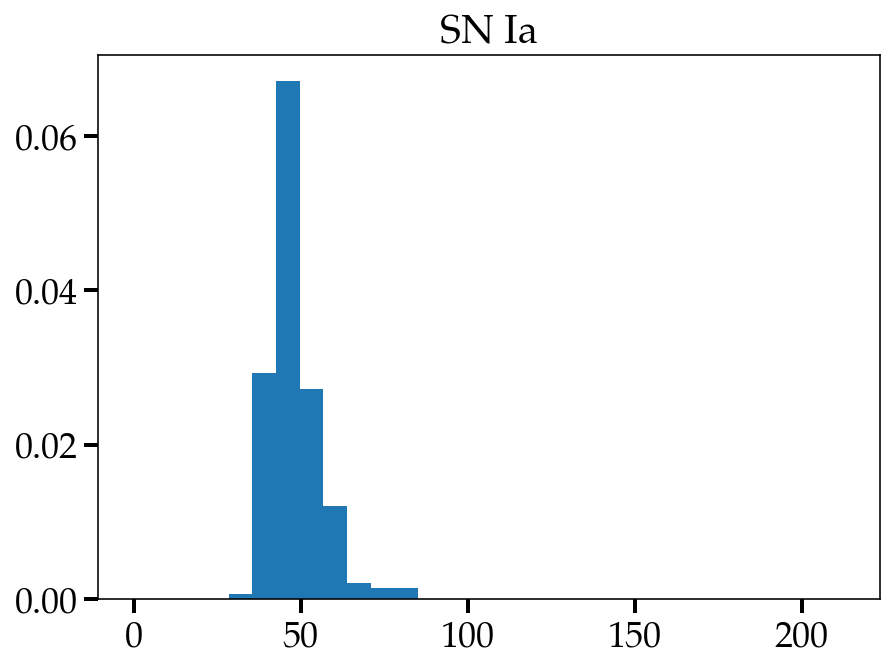

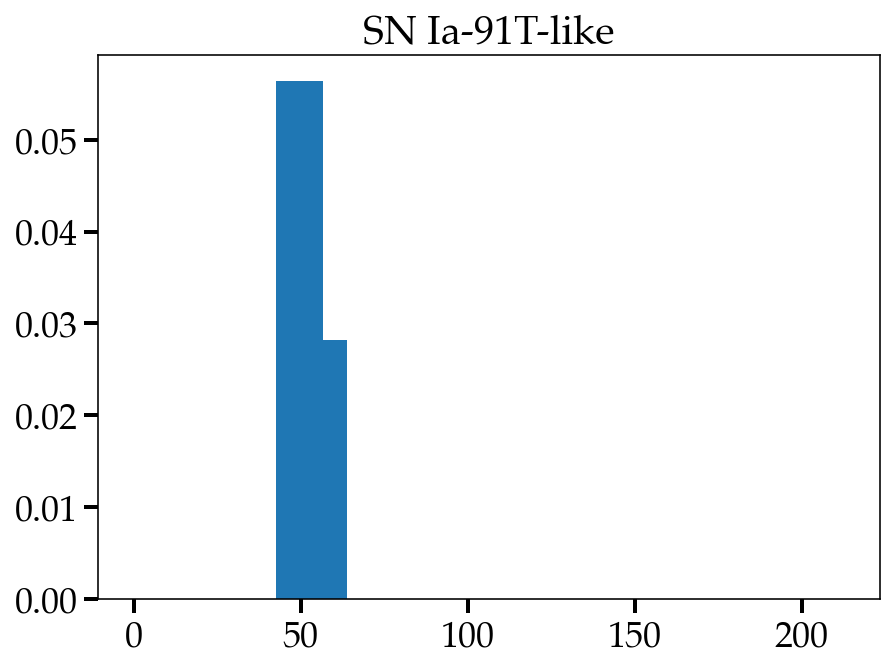

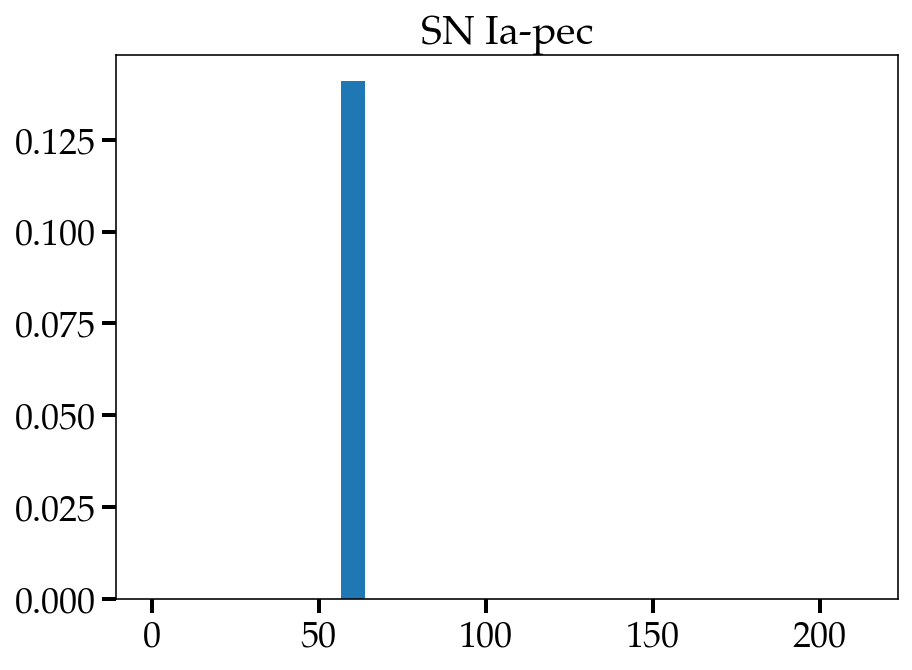

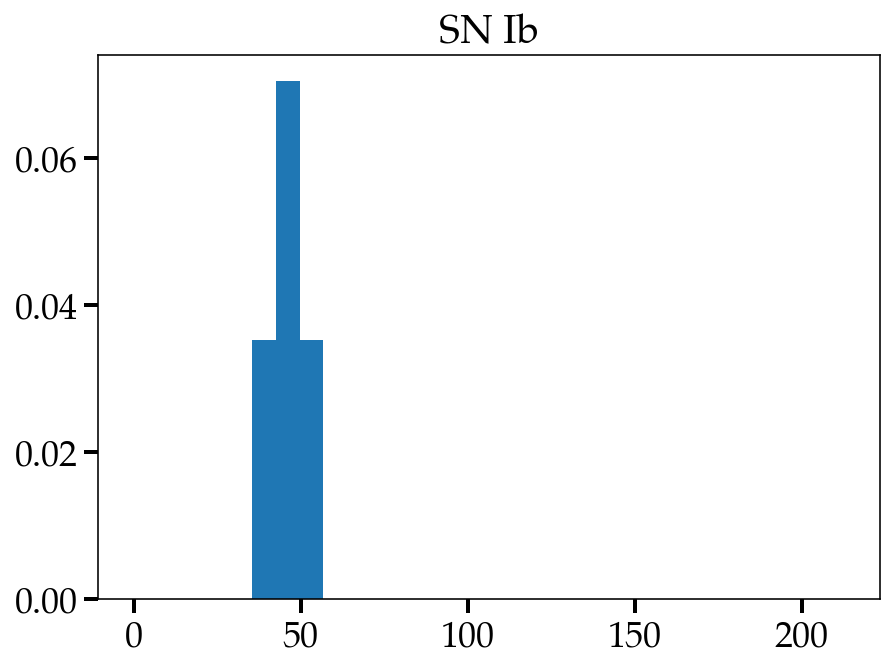

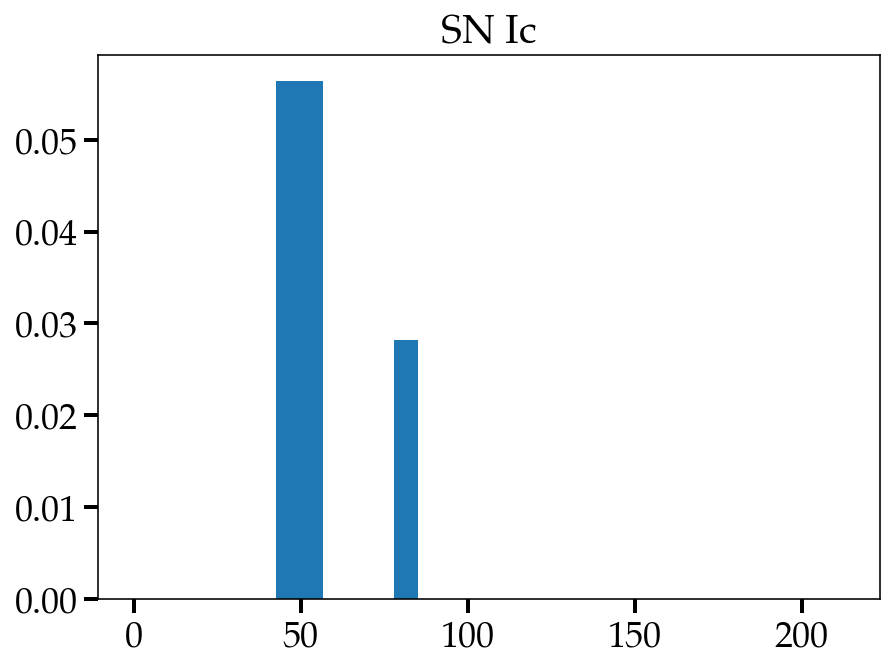

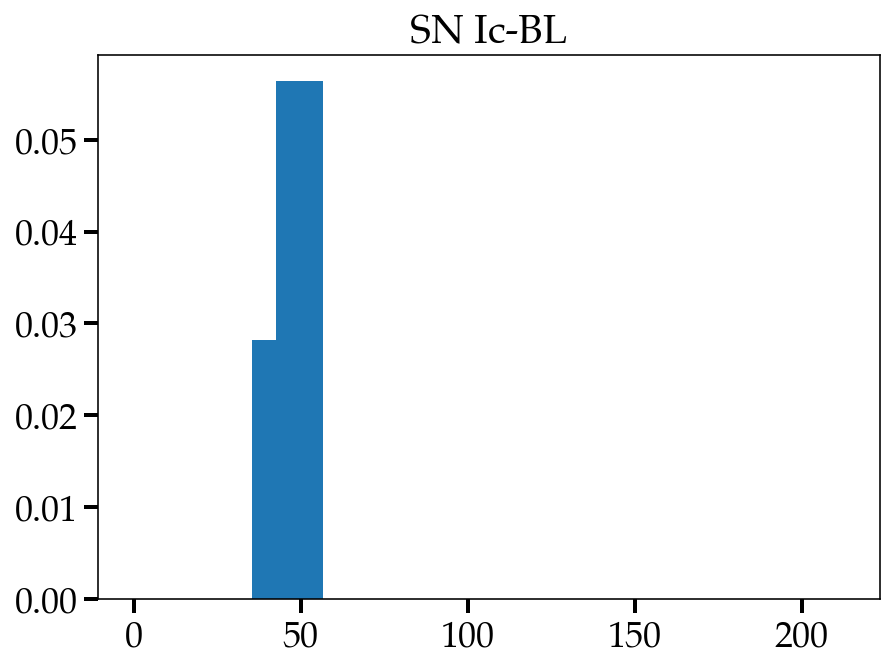

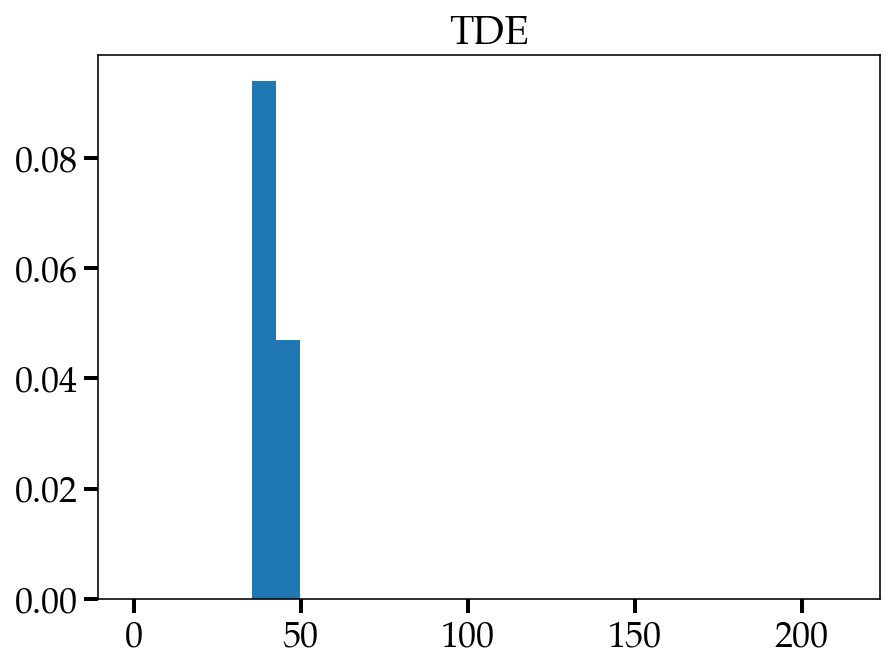

In [76]:
for cls in np.unique(merge_df.tns_cls):
    fig, ax = plt.subplots()
    
    merge_df_cls = merge_df[merge_df.tns_cls == cls]
    
    #ax.hist(merge_df_cls["WeightedMean-9ANNs"], bins=np.linspace(0, np.max(merge_df["WeightedMean-9ANNs"]), 31), density=True)
    ax.hist(merge_df_cls[dist_col], bins=np.linspace(0, np.max(merge_df[dist_col]), 31), density=True)
    
    ax.set_title(cls)
    #ax.set_xlim(0, 150)

/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


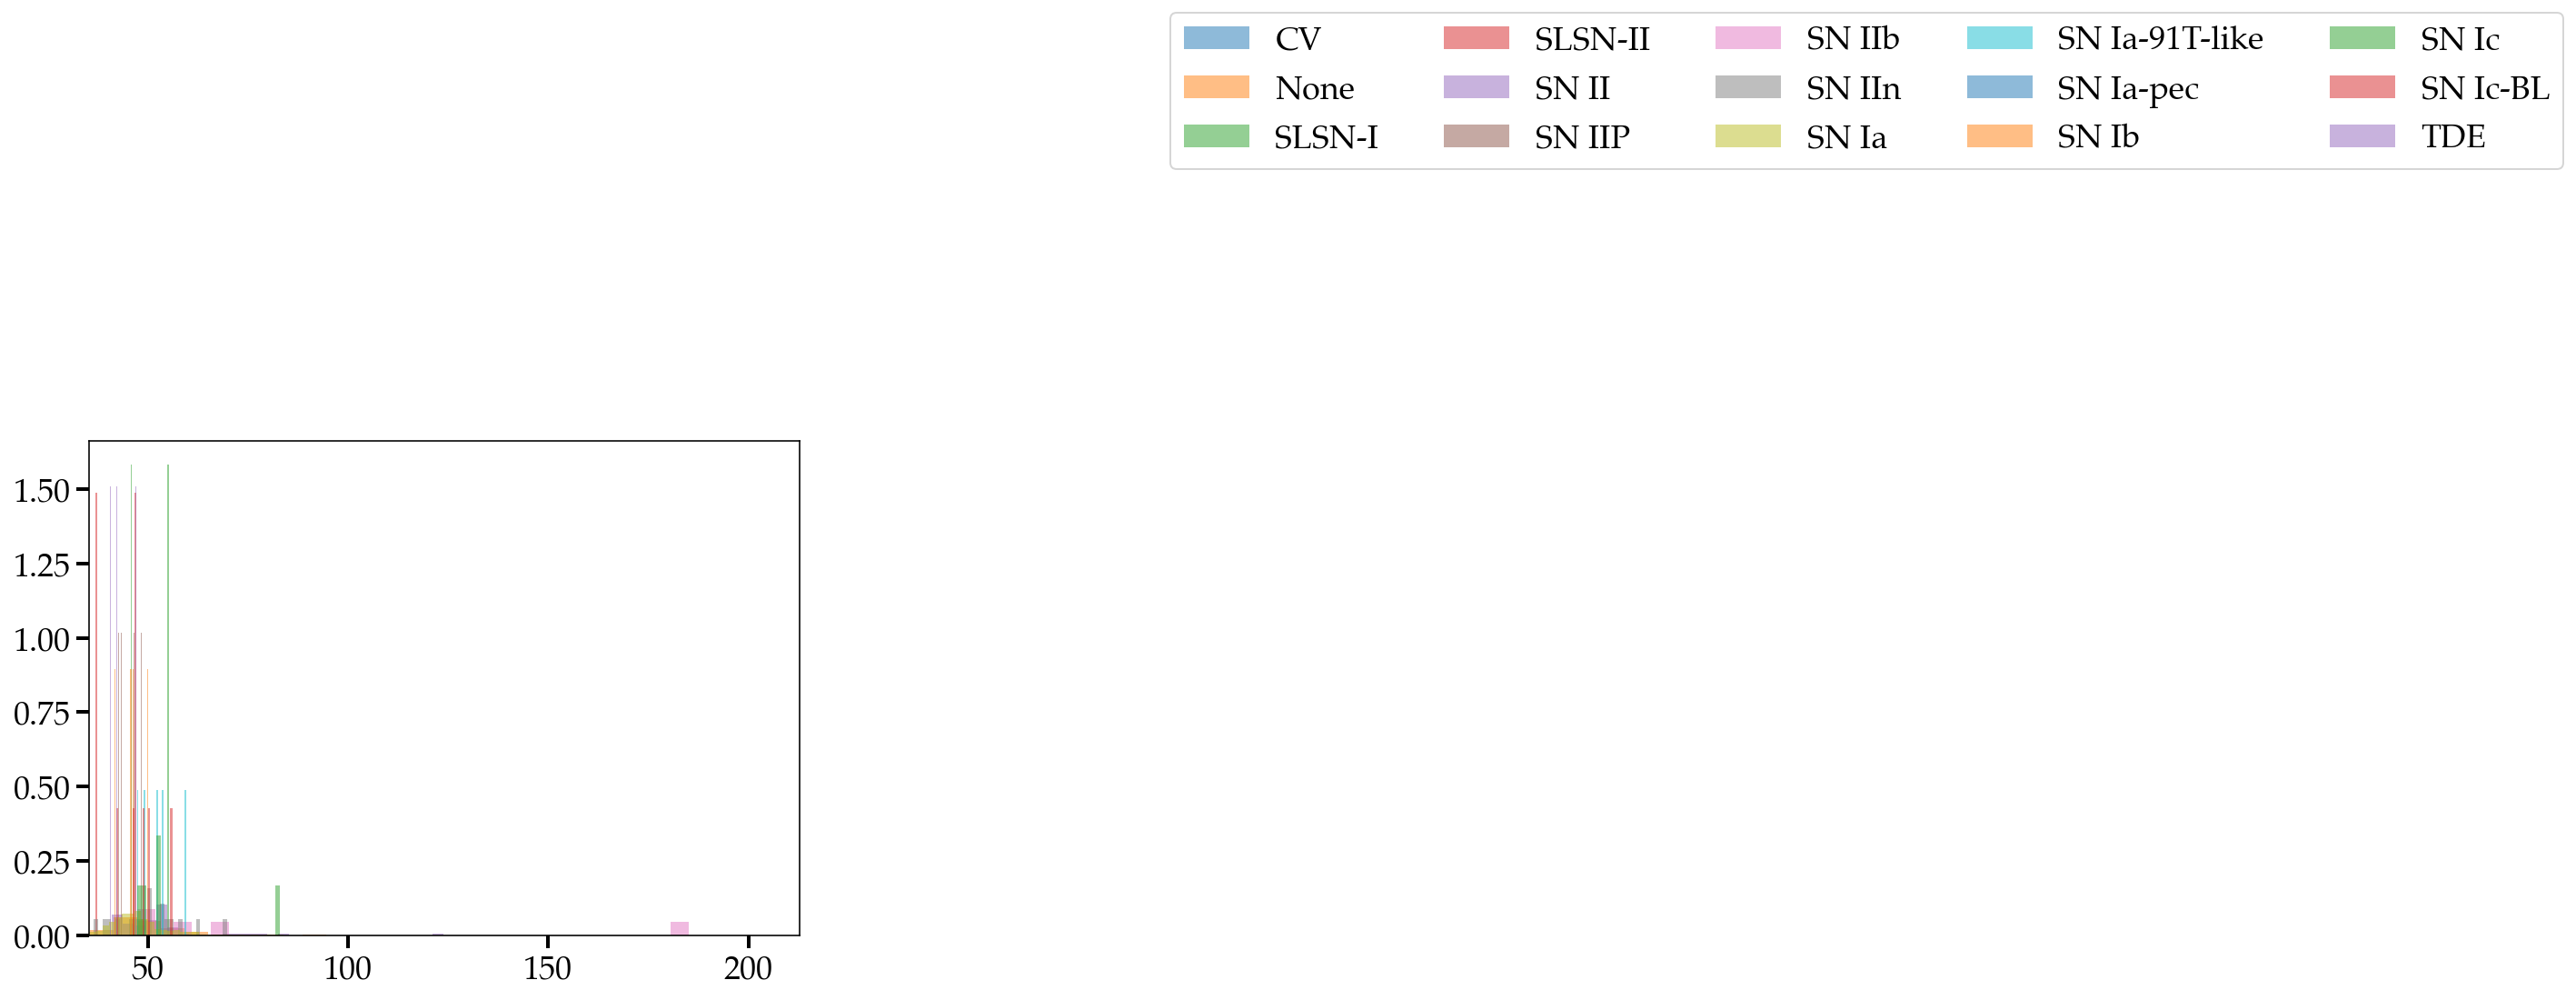

In [77]:
fig, ax = plt.subplots()

for cls in np.unique(merge_df.tns_cls):
    
    merge_df_cls = merge_df[merge_df.tns_cls == cls]
    
    #ax.hist(merge_df_cls["WeightedMean-9ANNs"], bins=np.linspace(0, 150, 31), 
    #        density=True, alpha=0.5, label=cls)
    
    ax.hist(merge_df_cls[dist_col], bins=np.linspace(np.min(merge_df_cls[dist_col]), np.max(merge_df_cls[dist_col]), 31), 
            density=True, alpha=0.5, label=cls)
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
plt.legend(ncol=5, bbox_to_anchor=(1.5,1.9))

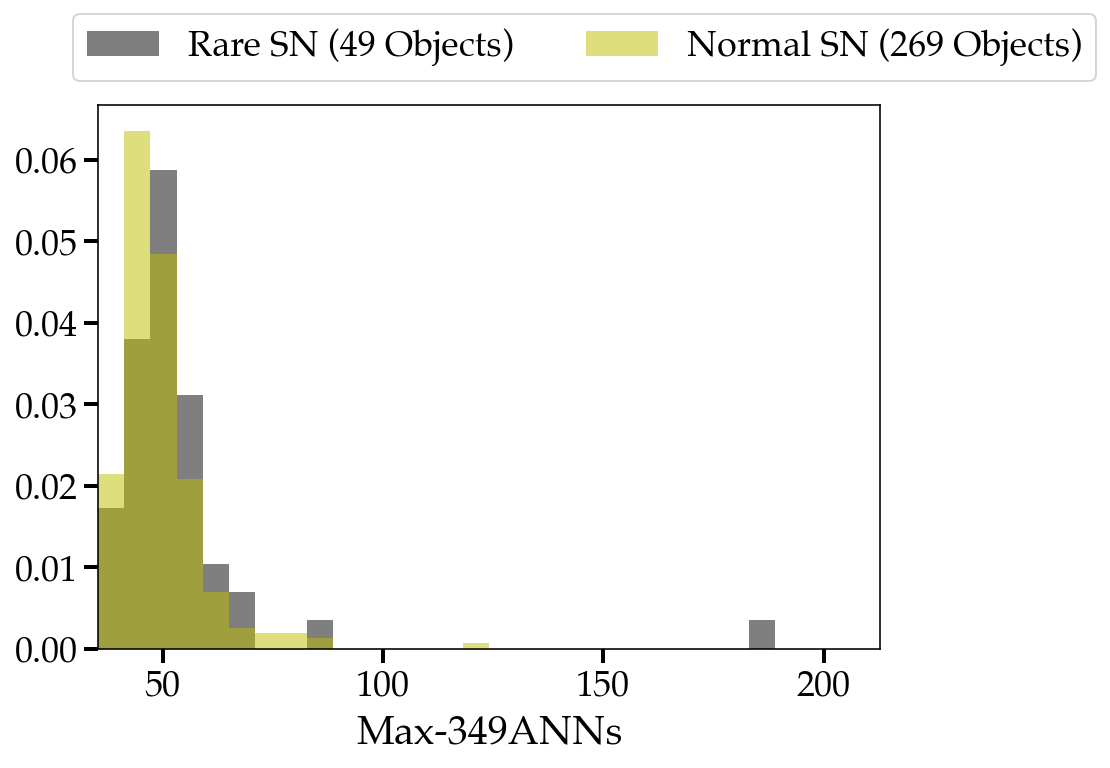

In [78]:
fig, ax = plt.subplots()
bins=np.linspace(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]), 31)
    

rare_sn_l = ['SLSN-I', 'SLSN-II', 'SN II-pec', 'SN IIb', 'SN IIn', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM',
   'SN Ia-pec', 'SN Iax[02cx-like]', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
   'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Icn', 'TDE']
rare_sn_df = merge_df[merge_df.tns_cls.isin(rare_sn_l)]
ax.hist(rare_sn_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN ({len(rare_sn_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_sn_l = ['SN', 'SN I', 'SN II', 'SN Ia']
normal_sn_df = merge_df[merge_df.tns_cls.isin(normal_sn_l)]
ax.hist(normal_sn_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN ({len(normal_sn_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
#plt.xscale('log')
plt.xlabel(dist_col)
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig(f'../figures/histograms/ann_dist_all_df_{suffix}_2cls_{dist_col}.png')
plt.show()

In [79]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test

# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_df[dist_col], size=len(rare_sn_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_df[dist_col], normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.22448979591836735
P-value: 0.23013119924776862
The two distributions are likely the same.


In [80]:
np.median(normal_sn_df[dist_col])

47.163822174072266

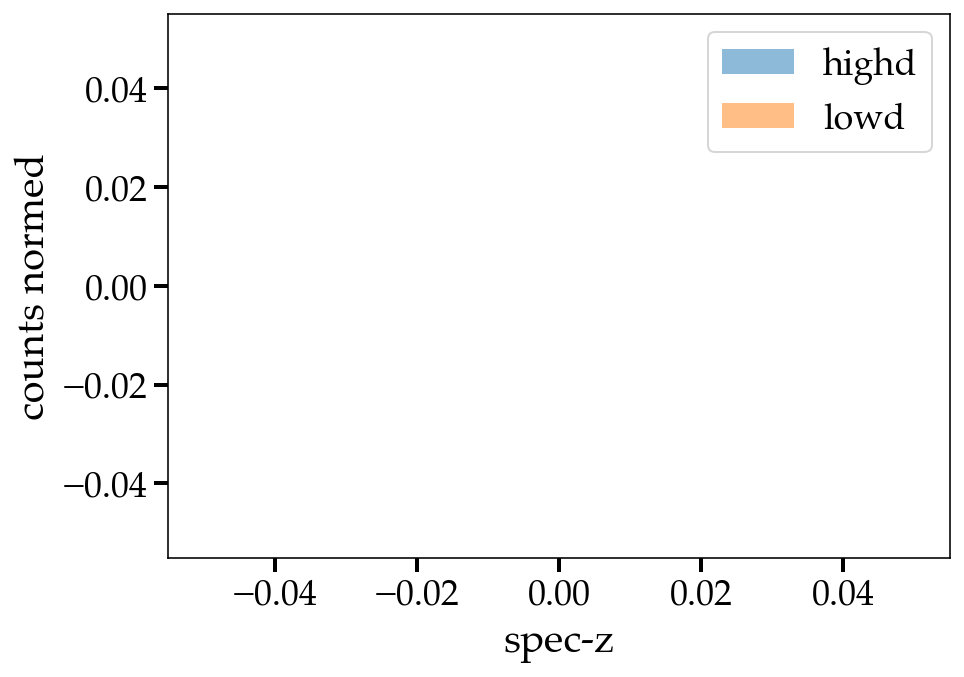

In [81]:
normal_sn_df = normal_sn_df[normal_sn_df.spec_z >= 0]

normal_sn_highd_df = normal_sn_df[normal_sn_df[dist_col] >= np.median(normal_sn_df[dist_col])+100]
normal_sn_lowd_df = normal_sn_df[normal_sn_df[dist_col] <= np.median(normal_sn_df[dist_col])+100]

bins=np.linspace(np.min(normal_sn_highd_df.spec_z), np.max(normal_sn_highd_df.spec_z), 31)
plt.hist(normal_sn_highd_df.spec_z, bins=bins, alpha=0.5, density=True, label='highd')
plt.hist(normal_sn_lowd_df.spec_z, bins=bins, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [82]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_lowd_df.spec_z, size=len(normal_sn_highd_df), replace=False)
    stat, p_value = ks_2samp(normal_sn_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

ValueError: Data passed to ks_2samp must not be empty

In [ ]:
np.median(rare_sn_df[dist_col])

In [ ]:
rare_sn_df = rare_sn_df[rare_sn_df.spec_z >= 0]

rare_sn_highd_df = rare_sn_df[rare_sn_df[dist_col] >= np.median(rare_sn_df[dist_col])+100]
rare_sn_lowd_df = rare_sn_df[rare_sn_df[dist_col] <= np.median(rare_sn_df[dist_col])+100]

bins=np.linspace(np.min(rare_sn_highd_df.spec_z), np.max(rare_sn_highd_df.spec_z), 31)
plt.hist(rare_sn_highd_df.spec_z, bins=bins, alpha=0.5, density=True, label='highd')
plt.hist(rare_sn_lowd_df.spec_z, bins=bins, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [ ]:
len(rare_sn_lowd_df)

In [ ]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(rare_sn_lowd_df.spec_z, size=len(rare_sn_highd_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

fig, ax = plt.subplots()
bins=np.linspace(25, 150, 31)
    

rare_sn_l = ['SLSN-I', 'SLSN-II', 'SN II-pec', 'SN IIb', 'SN IIn', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM',
   'SN Ia-pec', 'SN Iax[02cx-like]', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
   'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Icn', 'TDE']
rare_sn_df = merge_df[merge_df.tns_cls.isin(rare_sn_l)]
ax.hist(rare_sn_df["Mean-49ANNs"], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN ({len(rare_sn_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_sn_l = ['SN', 'SN I', 'SN II', 'SN Ia']
normal_sn_df = merge_df[merge_df.tns_cls.isin(normal_sn_l)]
ax.hist(normal_sn_df["Mean-49ANNs"], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN ({len(normal_sn_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(25, 150)
plt.xlabel('Mean-49ANNs')
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig('../figures/histograms/ann_dist_all_df_hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_2cls_Mean.png')
plt.show()

from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_df["Mean-49ANNs"], size=len(rare_sn_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_df["Mean-49ANNs"], normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

## No statistical difference between Rare SN and Normal SN 

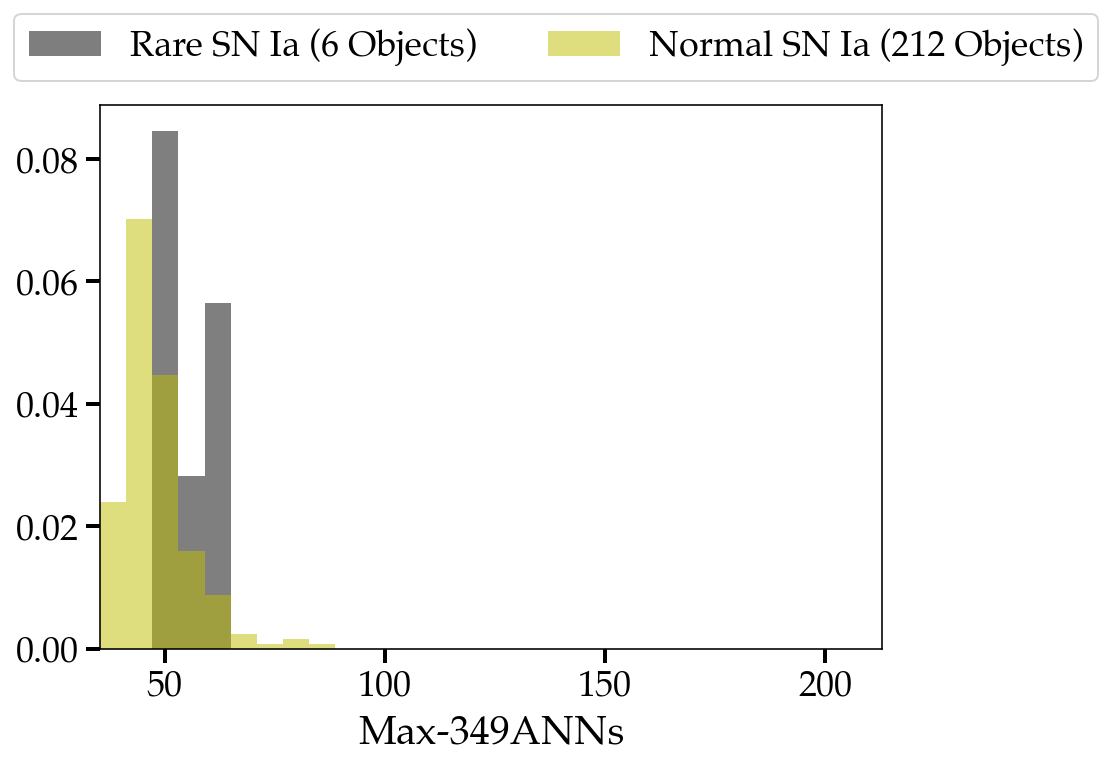

In [83]:
fig, ax = plt.subplots()
bins=np.linspace(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]), 31)
    

rare_snIa_l = ['SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM', 'SN Ia-pec', 'SN Iax[02cx-like]']
rare_snIa_df = merge_df[merge_df.tns_cls.isin(rare_snIa_l)]
ax.hist(rare_snIa_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN Ia ({len(rare_snIa_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_snIa_l = ['SN Ia']
normal_snIa_df = merge_df[merge_df.tns_cls.isin(normal_snIa_l)]
ax.hist(normal_snIa_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN Ia ({len(normal_snIa_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
plt.xlabel(dist_col)
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig(f'../figures/histograms/ann_dist_all_df_{suffix}_2cls_{dist_col}_Ia.png')
plt.show()

In [84]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_snIa_subsample = np.random.choice(normal_snIa_df[dist_col], size=len(rare_snIa_df), replace=False)
    stat, p_value = ks_2samp(rare_snIa_df[dist_col], normal_snIa_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.6666666666666666
P-value: 0.30839177489177483
The two distributions are likely the same.


## No statistical difference between Rare SN Ia and Normal SN Ia...

In [85]:
np.median(normal_snIa_df[dist_col])

46.801944732666016

In [86]:
normal_snIa_highd_df = normal_snIa_df[normal_snIa_df[dist_col] >= np.median(normal_snIa_df[dist_col])+100]
normal_snIa_lowd_df = normal_snIa_df[normal_snIa_df[dist_col] <= np.median(normal_snIa_df[dist_col])+100]

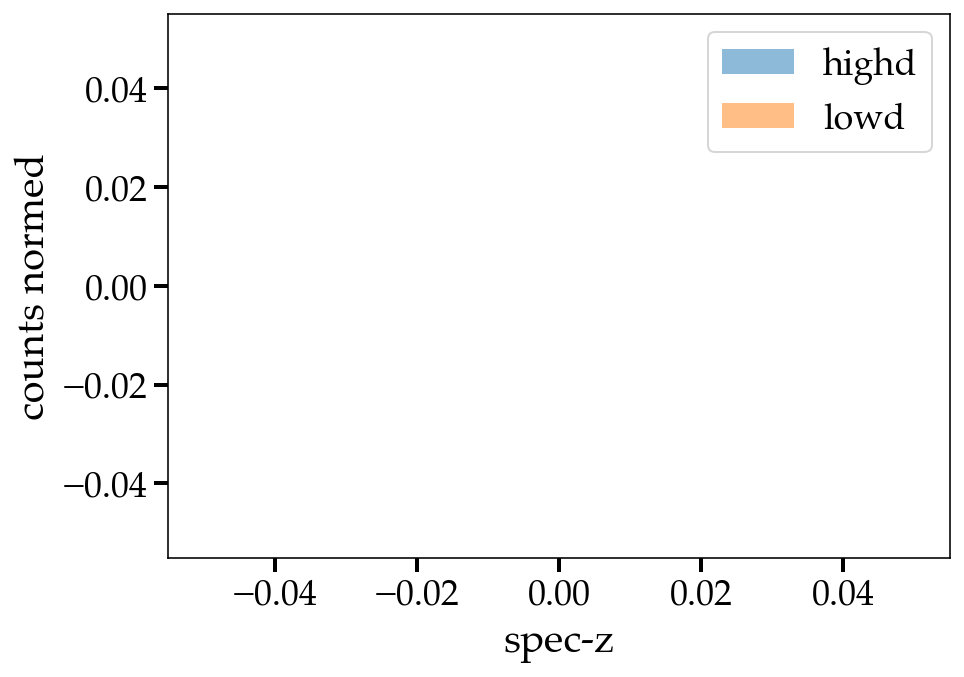

In [87]:
normal_snIa_highd_df = normal_snIa_highd_df[normal_snIa_highd_df.spec_z >= 0]

bins=np.linspace(np.min(normal_snIa_highd_df.spec_z), np.max(normal_snIa_highd_df.spec_z), 31)
plt.hist(normal_snIa_highd_df.spec_z, bins=bins, alpha=0.5, density=True, label='highd')
plt.hist(normal_snIa_lowd_df.spec_z, bins=bins, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [88]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_snIa_lowd_df.spec_z, size=len(normal_snIa_highd_df), replace=False)
    stat, p_value = ks_2samp(normal_snIa_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

ValueError: Data passed to ks_2samp must not be empty

In [89]:
np.median(rare_snIa_df[dist_col])

52.93202590942383

/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


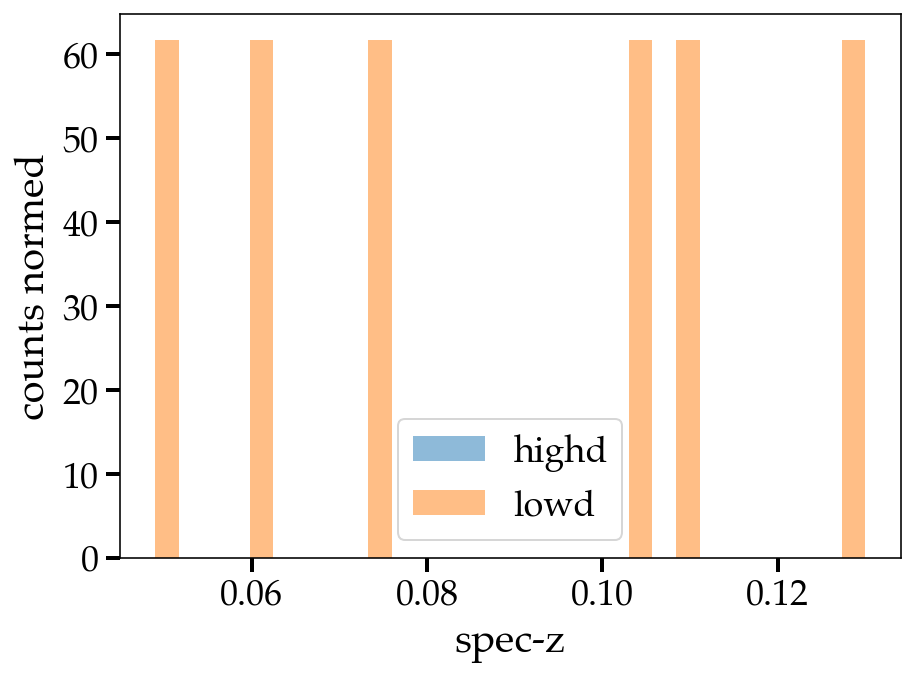

In [90]:
rare_snIa_df = rare_snIa_df[rare_snIa_df.spec_z>=0]

rare_snIa_highd_df = rare_snIa_df[rare_snIa_df[dist_col] >= np.median(rare_snIa_df[dist_col])+100]
rare_snIa_lowd_df = rare_snIa_df[rare_snIa_df[dist_col] <= np.median(rare_snIa_df[dist_col])+100]

bins=np.linspace(np.min(rare_snIa_df.spec_z), np.max(rare_snIa_df.spec_z), 31)

plt.hist(rare_snIa_highd_df.spec_z, bins=bins, alpha=0.5, density=True, label='highd')
plt.hist(rare_snIa_lowd_df.spec_z, bins=bins, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [91]:
len(rare_snIa_highd_df)

0

In [92]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(rare_snIa_lowd_df.spec_z, size=len(rare_snIa_highd_df), replace=False)
    stat, p_value = ks_2samp(rare_snIa_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

ValueError: Data passed to ks_2samp must not be empty

# Objs w/ high distances ANNs are Bright/closeby (generally...)
# TODO: how to define "rare"? --> Closeby & bright or rare phenomenology or ???
# Maybe "normalize out" brightness to focus on truly rare SN classes/types/ LCs?

# UPDATED: brightness CAN be normalized out (w/ l1 norm and MI_classif), but tradeoff between good similarity (and host galaxy). If host gal weights all = 0.008 (1/120), then sim is good but high d and low d correspond to low z and high z, respectively. However, if I don't overweight hosts, sim search is not as good but high d and low d DO NOT correspond to low z and high z. So high d and low d objects are not dependent on redshift! But still no diff between rare SN and normal SN ... :( ?

# L1 norm & MI_classif (+changes) normalizes brightness ANN d but not great at AD, but Standard Scaler & MI_classif (+changes) is good at Sim Search, but not great at AD. What is great at AD if features overlap??? Try other scalers?

## TODO: find a new method for really Rare SN!
## TODO: Also, find if Rare SN--> Rare SN and Normal SN --> Normal SN

In [93]:
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after"
#suffix="hasTNS-spec_NOpca_noCadence_NOtransf_HasHostGalOnly_SS"
#suffix="hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS"

full_ann_properties_df = pd.read_csv(f'../loci_dbs/alerce_cut/full_ann101_properties_df_{suffix}.csv', index_col=0)
full_ann_properties_df

,ann=0_ztfid,ann=1_ztfid,ann=2_ztfid,ann=3_ztfid,ann=4_ztfid,ann=5_ztfid,ann=6_ztfid,ann=7_ztfid,ann=8_ztfid,ann=9_ztfid,...,ann=91_spec_z,ann=92_spec_z,ann=93_spec_z,ann=94_spec_z,ann=95_spec_z,ann=96_spec_z,ann=97_spec_z,ann=98_spec_z,ann=99_spec_z,ann=100_spec_z
ZTF20acpmeuc,ZTF20acpmeuc,ZTF21aahdshq,ZTF20acunxkg,ZTF20acimsnl,ZTF21aaridvf,ZTF20acpcwwg,ZTF20adafguh,ZTF20achomxd,ZTF21aahrnpv,ZTF22aaajoxo,...,-99.0000,-99.0,-99.0,-99.000,-99.00000,0.1029,-99.000000,-99.000000,-99.0,-99.000
ZTF20acowuix,ZTF20acowuix,ZTF21aarohyu,ZTF21aapqzxr,ZTF21abhzsho,ZTF20acowutp,ZTF21aarnlkz,ZTF20acfnuee,ZTF19abvzwlq,ZTF20actoank,ZTF21aatklhw,...,0.1100,-99.0,-99.0,-99.000,0.09000,-99.0000,0.075000,0.098876,-99.0,0.097
ZTF21abfjruq,ZTF21abfjruq,ZTF18acbzvuu,ZTF21abyfkzb,ZTF21abigboa,ZTF21aaiaqvc,ZTF21abrsann,ZTF20acnbhsq,ZTFabc66452,ZTF22aaajife,ZTFabc86625,...,-99.0000,-99.0,-99.0,-99.000,-99.00000,-99.0000,-99.000000,-99.000000,-99.0,-99.000
ZTF22aaaxyzs,ZTF22aaaxyzs,ZTF21abtorlk,ZTF22aaaffjd,ZTF21absbrag,ZTF20acuxfhx,ZTF22aaafgdl,ZTF21abvvivq,ZTF18aansqov,ZTFabc66870,ZTF21abmwgdf,...,-99.0000,-99.0,-99.0,-99.000,-99.00000,-99.0000,-99.000000,-99.000000,-99.0,-99.000
ZTF21abnuldi,ZTF21abnuldi,ZTF21aavozbk,ZTF21aajdbhw,ZTF21abxnghi,ZTF20acyvbhj,ZTF21aaaajfe,ZTF20acjhhqx,ZTF21aapffqd,ZTF21abvcarc,ZTF20acriwfa,...,-99.0000,-99.0,-99.0,0.070,-99.00000,-99.0000,0.080000,-99.000000,-99.0,0.030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20aciymmp,ZTF20aciymmp,ZTF19abxgnga,ZTF19aauojsf,ZTF20aadbczt,ZTF21aadacxv,ZTF18aaytijy,ZTF21aaphpor,ZTF19aafmytc,ZTF20aavcqsi,ZTF20aciiejq,...,-99.0000,-99.0,-99.0,-99.000,-99.00000,-99.0000,-99.000000,-99.000000,-99.0,-99.000
ZTF20acwcfvx,ZTF20acwcfvx,ZTF21abcouxj,ZTF21aaqzqaa,ZTF21aaabaey,ZTF20acpkjsn,ZTF20acwombm,ZTF21aapvxnf,ZTF18acsowmi,ZTF20acjsazw,ZTFabc04534,...,0.0545,-99.0,-99.0,-99.000,0.07363,-99.0000,0.050822,-99.000000,-99.0,-99.000
ZTF18adarvpj,ZTF18adarvpj,ZTF21aapzbhc,ZTF18adaliyg,ZTF21abxneyi,ZTF21abmcpny,ZTF18acnneyt,ZTF21aaiqdkm,ZTF21acipjfn,ZTF21aalhqhx,ZTF18acchhpe,...,-99.0000,-99.0,-99.0,-99.000,-99.00000,-99.0000,-99.000000,-99.000000,-99.0,-99.000
ZTF21aatrtbu,ZTF21aatrtbu,ZTF21aagscbh,ZTF21aaannfk,ZTF21abeguum,ZTF21aaxtfri,ZTF21acehjmb,ZTF21aavcqws,ZTF21abvdrrg,ZTF21aasjmcv,ZTF20acnzzlo,...,-99.0000,-99.0,-99.0,0.098,-99.00000,-99.0000,0.093000,-99.000000,-99.0,-99.000


In [94]:
full_ann_tns_cls_df = full_ann_properties_df.iloc[:, 303:404]
full_ann_tns_cls_df

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF20acpmeuc,None,None,None,None,SN Ia,None,None,None,None,SN Ia,...,TDE,None,None,SN Ia,SN Ia,SN Ia,None,SN Ia,None,None
ZTF20acowuix,SN Ia,SN Ia,SN Ia,None,None,None,SN Ia,SN Ia,None,SN Ia,...,SN Ia,SN Ia,SN Ic-BL,SN Ic-BL,SN Ia,None,SN Ia-91T-like,SN Ia,None,SN Ia
ZTF21abfjruq,None,None,None,None,None,None,None,SLSN-II,SN Ia,SLSN-II,...,SLSN-II,None,None,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,None,SLSN-II
ZTF22aaaxyzs,SN Ia-pec,SN IIn,None,SN Ia,None,SN Ia,SN Ia,SN Ia,SN IIn,SN Ia,...,SN IIn,None,None,None,None,SN IIn,SN IIn,SN II,None,None
ZTF21abnuldi,SN IIb,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN II,SN Ia,SN Ia,...,SN Ia-91T-like,SLSN-II,SN IIb,SN Ia,SN Ia-91T-like,SN Ia-91T-like,SN Ia,SN II,None,SN IIn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20aciymmp,None,None,None,None,SN II,None,None,None,None,None,...,None,SN II,None,None,None,None,None,SN Ia-91T-like,None,None
ZTF20acwcfvx,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia-91T-like,None,SN Ia,SN Ia,...,SN Ia,SN Ia,SN Ic,SN Ia-pec,SN Ia,SN Ia-pec,SN Ia,SN Ic-BL,SN Ia-91T-like,SN Ia
ZTF18adarvpj,None,None,None,None,None,None,None,None,None,None,...,SN Ia,None,None,None,None,None,None,None,None,None
ZTF21aatrtbu,None,None,None,None,None,None,None,None,None,None,...,None,None,None,SN Ia,None,None,SN Ia,None,None,None


In [95]:
full_ann_spec_z_df = full_ann_properties_df.iloc[:, 404:505]
full_ann_spec_z_df

,ann=0_spec_z,ann=1_spec_z,ann=2_spec_z,ann=3_spec_z,ann=4_spec_z,ann=5_spec_z,ann=6_spec_z,ann=7_spec_z,ann=8_spec_z,ann=9_spec_z,...,ann=91_spec_z,ann=92_spec_z,ann=93_spec_z,ann=94_spec_z,ann=95_spec_z,ann=96_spec_z,ann=97_spec_z,ann=98_spec_z,ann=99_spec_z,ann=100_spec_z
ZTF20acpmeuc,-99.000,-99.00000,-99.0000,-99.00000,0.12000,-99.000000,-99.000,-99.000000,-99.000000,0.07800,...,-99.0000,-99.0,-99.0,-99.000,-99.00000,0.1029,-99.000000,-99.000000,-99.0,-99.000
ZTF20acowuix,0.090,0.06300,0.1035,-99.00000,-99.00000,-99.000000,0.060,0.065000,-99.000000,0.06689,...,0.1100,-99.0,-99.0,-99.000,0.09000,-99.0000,0.075000,0.098876,-99.0,0.097
ZTF21abfjruq,-99.000,-99.00000,-99.0000,-99.00000,-99.00000,-99.000000,-99.000,-99.000000,0.060000,-99.00000,...,-99.0000,-99.0,-99.0,-99.000,-99.00000,-99.0000,-99.000000,-99.000000,-99.0,-99.000
ZTF22aaaxyzs,0.049,0.03100,-99.0000,0.07900,-99.00000,0.032726,0.079,0.070000,-99.000000,0.07400,...,-99.0000,-99.0,-99.0,-99.000,-99.00000,-99.0000,-99.000000,-99.000000,-99.0,-99.000
ZTF21abnuldi,0.035,0.07200,0.0400,0.04600,0.07848,0.050000,0.040,0.052896,0.022609,0.04185,...,-99.0000,-99.0,-99.0,0.070,-99.00000,-99.0000,0.080000,-99.000000,-99.0,0.030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20aciymmp,-99.000,-99.00000,-99.0000,-99.00000,0.05100,-99.000000,-99.000,-99.000000,-99.000000,-99.00000,...,-99.0000,-99.0,-99.0,-99.000,-99.00000,-99.0000,-99.000000,-99.000000,-99.0,-99.000
ZTF20acwcfvx,0.077,0.06218,0.0640,0.06569,0.05600,0.124000,0.085,-99.000000,0.060260,-99.00000,...,0.0545,-99.0,-99.0,-99.000,0.07363,-99.0000,0.050822,-99.000000,-99.0,-99.000
ZTF18adarvpj,-99.000,-99.00000,-99.0000,-99.00000,-99.00000,-99.000000,-99.000,-99.000000,-99.000000,-99.00000,...,-99.0000,-99.0,-99.0,-99.000,-99.00000,-99.0000,-99.000000,-99.000000,-99.0,-99.000
ZTF21aatrtbu,-99.000,-99.00000,-99.0000,-99.00000,-99.00000,-99.000000,-99.000,-99.000000,-99.000000,-99.00000,...,-99.0000,-99.0,-99.0,0.098,-99.00000,-99.0000,0.093000,-99.000000,-99.0,-99.000


In [118]:
# Create Graph df
graph_df = pd.DataFrame()
graph_df['node'] = full_ann_tns_cls_df["ann=0_tns_cls"]

ann_num = 11
ann_tns_cls_col_list= [f'ann={col}_tns_cls' for col in range(1, ann_num)]
graph_df['neighbors'] = full_ann_tns_cls_df[ann_tns_cls_col_list].apply(list, axis=1)
graph_df

,node,neighbors
ZTF20acpmeuc,None,"[None, None, None, SN Ia, None, None, None, No..."
ZTF20acowuix,SN Ia,"[SN Ia, SN Ia, None, None, None, SN Ia, SN Ia,..."
ZTF21abfjruq,None,"[None, None, None, None, None, None, SLSN-II, ..."
ZTF22aaaxyzs,SN Ia-pec,"[SN IIn, None, SN Ia, None, SN Ia, SN Ia, SN I..."
ZTF21abnuldi,SN IIb,"[SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN ..."
...,...,...
ZTF20aciymmp,None,"[None, None, None, SN II, None, None, None, No..."
ZTF20acwcfvx,SN Ia,"[SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN Ia-91T-..."
ZTF18adarvpj,None,"[None, None, None, None, None, None, None, Non..."
ZTF21aatrtbu,None,"[None, None, None, None, None, None, None, Non..."


In [119]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ia-91T-like']

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF21aaafjad,SN Ia-91T-like,None,None,SN Ib,SN Ia,SN Ia,None,None,None,None,...,SN Ia,SN Ib,SN Ia,SN Ib,SN Ib,None,SN Ia,SN Ib,None,SN Ia
ZTF20achuvhd,SN Ia-91T-like,None,None,None,None,None,None,None,None,None,...,None,None,None,SN Ia,None,None,None,None,SN Ia,None
ZTF21aarycyl,SN Ia-91T-like,SN Ia,None,None,None,None,None,None,SN Ia,SN Ia,...,SN II,None,None,None,None,SN Ia,None,SN IIb,None,None
ZTF21aaafrnh,SN Ia-91T-like,None,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN Ia,SN Ia,SN Ib,SN Ia,SN Ia-pec,SN Ia,SN Ia,SN Ia-91T-like,SN IIb,None
ZTF21aagnvvk,SN Ia-91T-like,None,SN Ia-91T-like,None,None,None,None,SN Ia-91T-like,None,None,...,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia,SN Ia,None,SN Ia-91T-like,None,SN Ia-91T-like,None


In [120]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ia']

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF20acowuix,SN Ia,SN Ia,SN Ia,None,None,None,SN Ia,SN Ia,None,SN Ia,...,SN Ia,SN Ia,SN Ic-BL,SN Ic-BL,SN Ia,None,SN Ia-91T-like,SN Ia,None,SN Ia
ZTF18acsofdh,SN Ia,SN Ia,None,None,SN Ia,SN Ia,SN Ic-BL,SN Ia,None,SN Ia,...,SN Ia,SN Ic-BL,SN Ic-BL,SN Ia-91T-like,None,SN Ic-BL,SN Ia,SN Ia,SN Ic-BL,SN Ic-BL
ZTF21abjwvzu,SN Ia,SN Ia,SN II,SN Ia,SN Ia,SN IIn,SN II,SN II,SN II,SN II,...,SN IIn,SN IIn,SN IIn,SN II,SN IIb,SN IIb,SN IIn,SN II,SN IIb,SN II
ZTF20abxyajd,SN Ia,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,...,SN IIb,SN IIb,SN IIb,SN Ic,SN IIb,SN IIb,SN IIb,SN Ic,SN Ia,SN Ic
ZTF20acbovrt,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN Ia-91T-like,SN Ia,SN Ia,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN Ia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20aclxbwk,SN Ia,None,None,None,None,None,SN Ia,None,SN IIn,None,...,SN Ia-91T-like,SN IIn,None,None,SN Ic,SN Ic,SN Ic,None,SN Ia-91T-like,None
ZTF21abrghol,SN Ia,SN Ia,SN Ia-91T-like,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia-91T-like,SN Ia-91T-like,SN Ia,...,SN Ia-pec,SN Ia,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN II,SN Ib,SN Ia-91T-like,SN Ia-91T-like,SN Ia
ZTF21aajvtsq,SN Ia,None,None,None,SN Ia,SN Ia,SN Ia,None,None,None,...,None,SN Ia,SN Ia,SN Ia,SN Ia,None,SN Ia,None,SN Ia-91T-like,SN II
ZTF21abtxnir,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN Ic,SN IIb,SN Ic,SN Ia,SN Ib,SN Ia,SN Ia,SN Ia,SN Ia,SN IIb


In [121]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ic']

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF20actekrw,SN Ic,SN Ia,SN II,SN II,None,SN II,SN II,SN Ia,SN IIP,SN Ia,...,SN IIP,SN Ic-BL,None,None,SN IIP,SN Ic-BL,SN Ic,SN IIP,SN Ic,SN Ic
ZTF20adadrhw,SN Ic,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN Ia,SN IIb,SN IIb,...,SN IIb,SN IIb,SN IIb,SN IIb,SN Ia,SN Ia,SN Ia,SN IIb,SN IIb,SN IIb
ZTF21aaqldsk,SN Ic,SN Ia,SN II,None,None,SN II,None,SN Ia,None,SN Ia,...,SN Ib,SN Ia,SN Ic,SN Ia-91T-like,SN IIn,SN Ib,SN Ib,SN Ia,SN II,SN II
ZTF20abwxywy,SN Ic,SN II,SN Ia,SN II,SN Ia-91T-like,SN Ic,SN Ia,SN IIn,SN II,SN II,...,SN Ia,SN Ic,SN Ic,SN IIb,SN II,SN IIb,SN IIb,SN II,SN Ic,SN IIn
ZTF20accoccp,SN Ic,SN Ia,SN Ia,SN Ia,None,SN Ia,SN Ia,None,SN Ia,SN Ia,...,None,SN IIb,SN Ia,SN II,SN Ia,SN IIb,None,SN Ia,SN Ic,SN Ic-BL


In [122]:
# https://alerce.online/object/ZTF20aclnplo - small double bump Ic. LC looks Ia like. Spec is more Ic than Ia but not obvious
# https://alerce.online/object/ZTF20accoccp - lc also looks somewhat Ia ish
# 

In [123]:
Counter(graph_df['node'])

Counter({'None': 757,
         'SN Ia': 212,
         'SN Ia-pec': 1,
         'SN IIb': 5,
         'SN II': 57,
         'SN Ia-91T-like': 5,
         'SN IIP': 5,
         'SN IIn': 17,
         'TDE': 4,
         'SN Ib': 4,
         'SLSN-I': 2,
         'CV': 2,
         'SN Ic': 5,
         'SN Ic-BL': 5,
         'SLSN-II': 2})

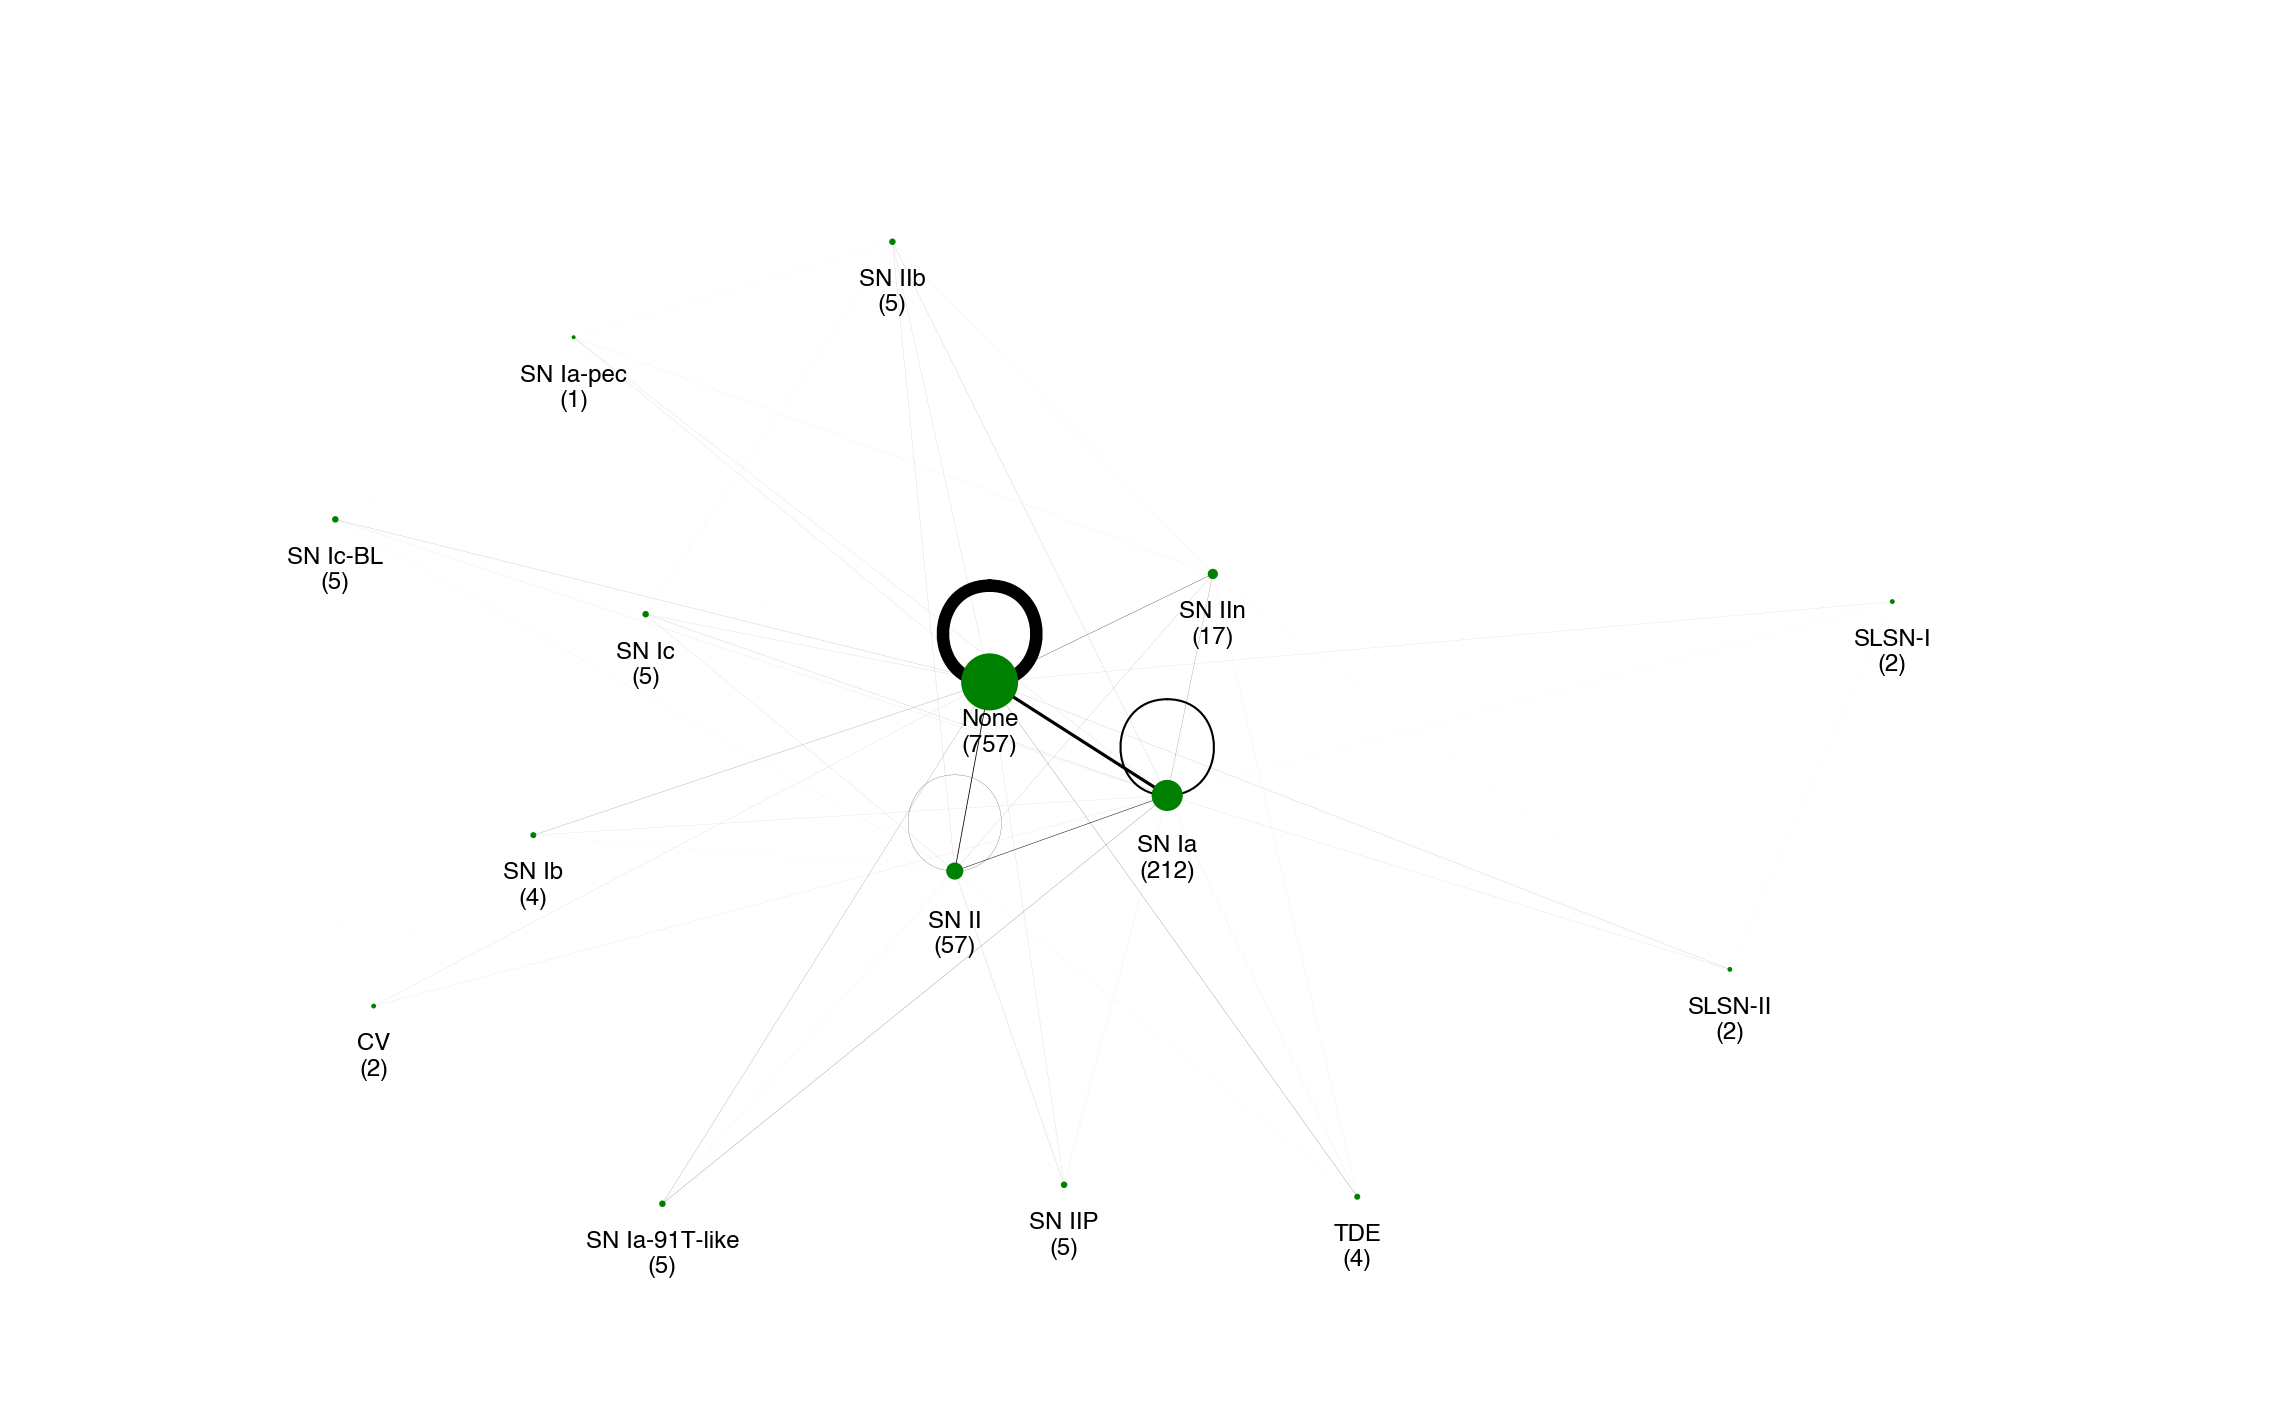

In [124]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


# Create a sample dataframe with node and edge data
df = graph_df.copy()
# Create a list of edges
edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

# Create a network graph from the edges
G = nx.Graph()
G.add_edges_from(edges)

# Compute the frequency of each unique connection
edge_freq = {}
for u, v in edges:
    key = (min(u, v), max(u, v))
    edge_freq[key] = edge_freq.get(key, 0) + 1
    
# Add edge labels with frequency
edge_labels = {}
for u, v, d in G.edges(data=True):
    key = (min(u, v), max(u, v))
    #if edge_freq[key] >= 500:
    edge_labels[(u, v)] = str(edge_freq[key])
    
# set edge widths based on frequency
edge_widths = [int(edge_labels[edge])/1000 for edge in edge_labels]

node_count = dict(Counter(graph_df['node']))

# Scale the node sizes by the occurrences of the node
#node_sizes = [1.2 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]

# for 80-20
# node_count.update({'SN Ibn': 0})

# for 80-20 v2
node_count.update({'SN Ibn': 0})
node_count.update({'SN Ia-91bg-like': 0})
node_count.update({'SN I': 0})
node_sizes = [node_count[node] * 1 for node in G.nodes()]
#print(node_sizes)

# Plot the graph
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(16, 10))
nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

# Move the labels of the nodes down right below the node
pos_labels = {}
for key, value in pos.items():
    pos_labels[key] = (value[0], value[1] - 0.07)
    
# # count the number of times of each node 
# node_count = dict(Counter(df['node']))

# scale node sizes by frequency
#node_sizes = [node_count[node] * 9 for node in G.nodes()]

# create labels with node and count information
node_labels_d1 = {node: f"{node}\n({node_count[node]})" for node in G.nodes() if node!='SN Ia' and node!='SN II'}
node_labels_d2 = {node: f"\n{node}\n({node_count[node]})" for node in G.nodes() if node=='SN II'}
node_labels = {node: f"\n{node}\n({node_count[node]})" for node in G.nodes() if node=='SN Ia'}


node_labels_d2.update(node_labels_d1)
node_labels.update(node_labels_d2)

nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')

plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()


folder_path = f"../figures/graphs/{suffix}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
plt.savefig(f'../figures/graphs/{suffix}/all_classes_network_size_scaled_ann{ann_num}.jpg', dpi=300)
plt.show()


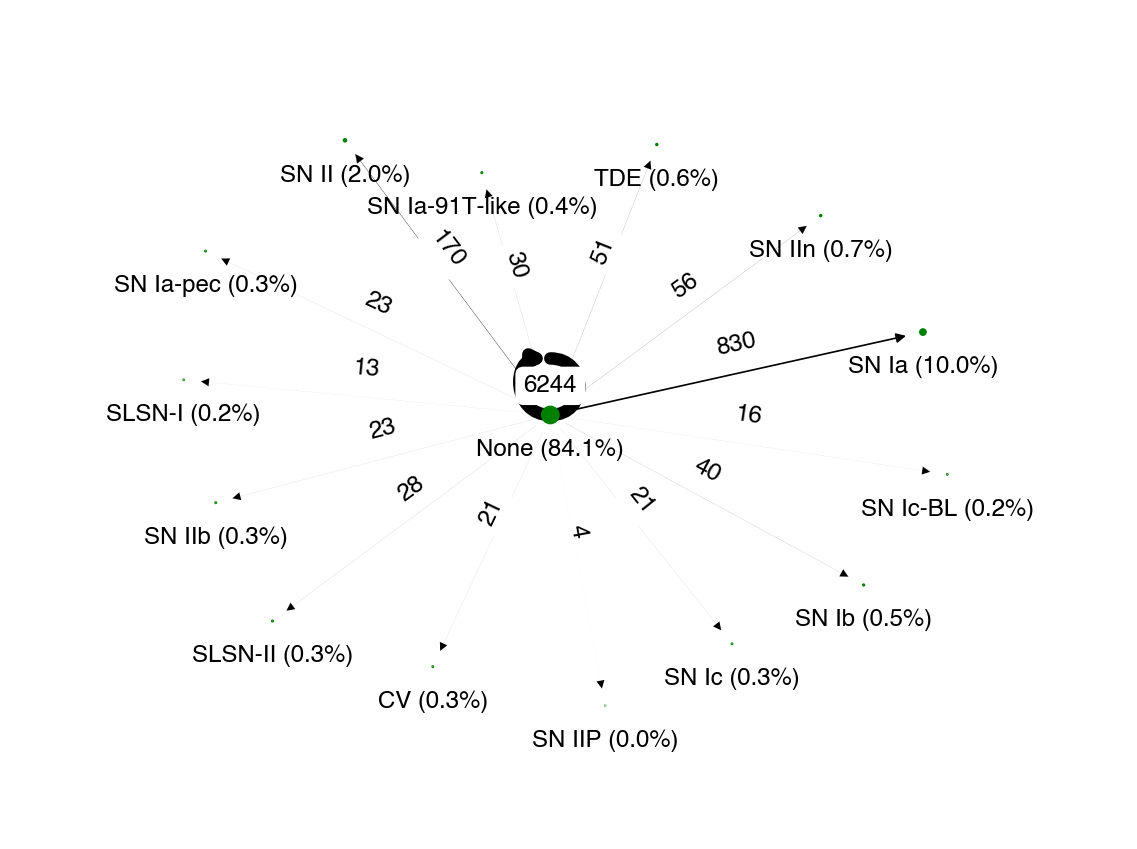

In [125]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

cls = 'None'
graph_df_cls = graph_df[graph_df.node == cls]


# Create a sample dataframe with node and edge data
df = graph_df_cls
# Create a list of edges
edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

# Create a network graph from the edges
G = nx.DiGraph()
G.add_edges_from(edges)

# Compute the frequency of each unique connection
edge_freq = {}
for u, v in edges:
    key = (min(u, v), max(u, v))
    edge_freq[key] = edge_freq.get(key, 0) + 1
    
# Add edge labels with frequency
edge_labels = {}
for u, v, d in G.edges(data=True):
    key = (min(u, v), max(u, v))
    #if edge_freq[key] >= 500:
    edge_labels[(u, v)] = str(edge_freq[key])
    
# set edge widths based on frequency
edge_widths = [int(edge_labels[edge])/1000 for edge in edge_labels]

# Scale the node sizes by the occurrences of the node
#node_sizes = [10 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
#print(node_sizes)

# explode the lists in the second column into separate rows
df = graph_df_cls
df_expl = df.explode('neighbors')

# group the data frame by the label column and count the number of unique values for each group
unique_node_d = dict(Counter(df['node']))
unique_neighbors_d = dict(Counter(df_expl['neighbors']))

for key in unique_neighbors_d:
    if key in unique_node_d:
        unique_node_d[key] += unique_neighbors_d[key]
    else:
        unique_node_d[key] = unique_neighbors_d[key]
        
node_count = unique_node_d
node_sizes = [node_count[node] * 0.01 for node in G.nodes()]
#print(node_sizes)

# Plot the graph
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

# Move the labels of the nodes down right below the node
pos_labels = {}
for key, value in pos.items():
    pos_labels[key] = (value[0], value[1] +.1)
    
    
# # count the number of times of each node 
# node_count = dict(Counter(graph_df_cv['node']))

# # scale node sizes by frequency
# node_sizes = [node_count[node] * 9 for node in G.nodes()]

# create labels with node and count information
#True Counts
node_labels = {node: f"\n\n\n\n\n{node} ({node_count[node]})" for node in G.nodes()}
#Percentage
node_counts = [node_count[node] for node in G.nodes()]
node_classes = [node for node in G.nodes()]
node_labels = {ncls: f"\n\n\n\n\n{ncls} ({round((nc/sum(node_counts))*100, 1)}%)" for ncls, nc in zip(node_classes, node_counts)}


nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

nx.draw_networkx_edge_labels(G, pos_labels, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')


plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()
#plt.savefig(f'../figures/graphs/{suffix}_size_scaled_None.jpg', dpi=300)
plt.show()


CV


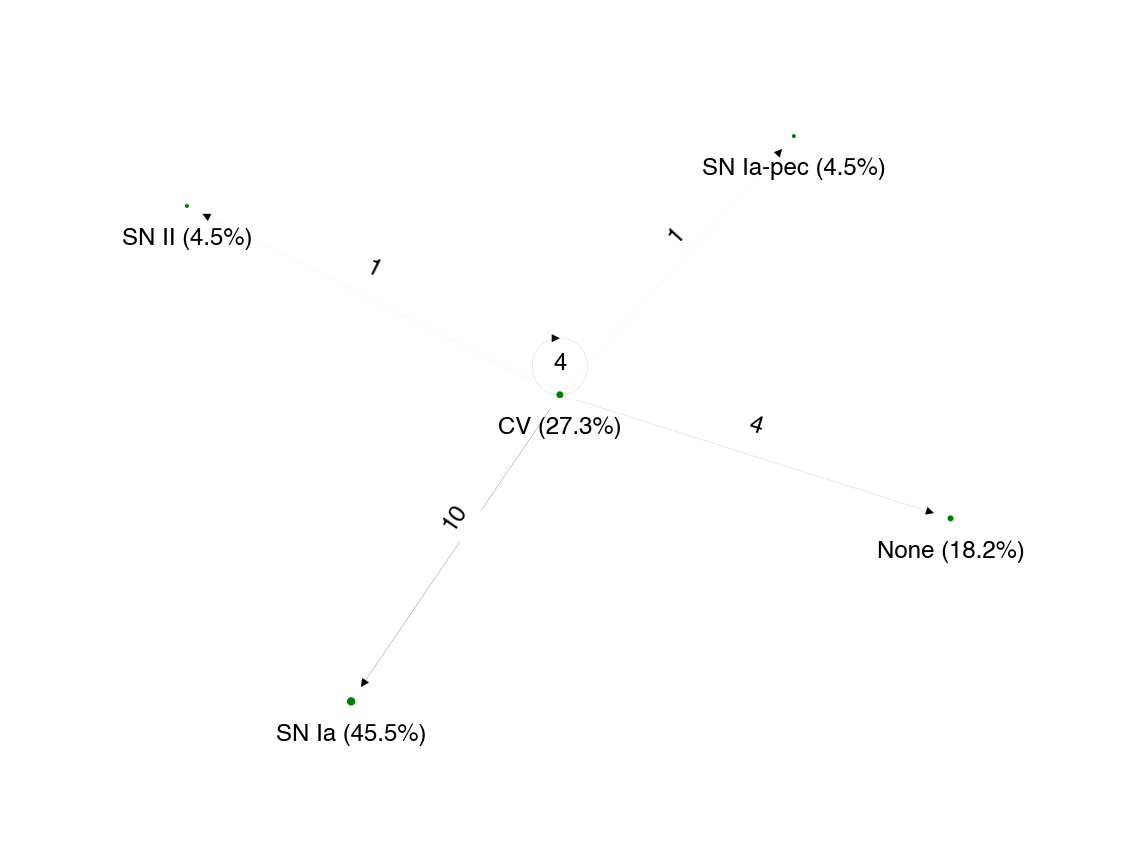

None


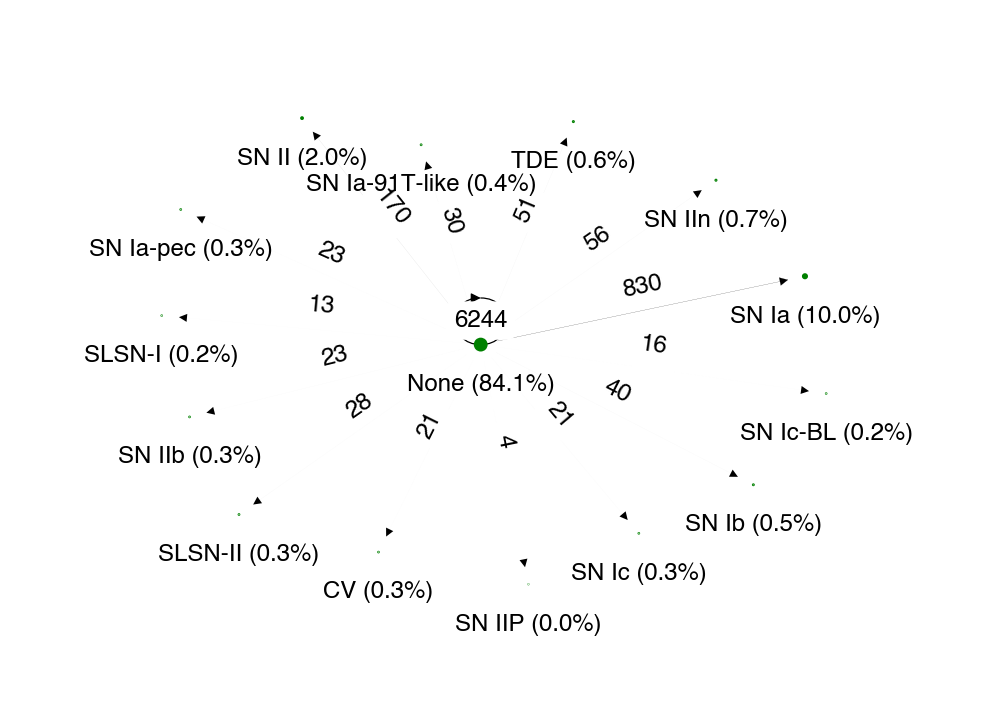

SLSN-I


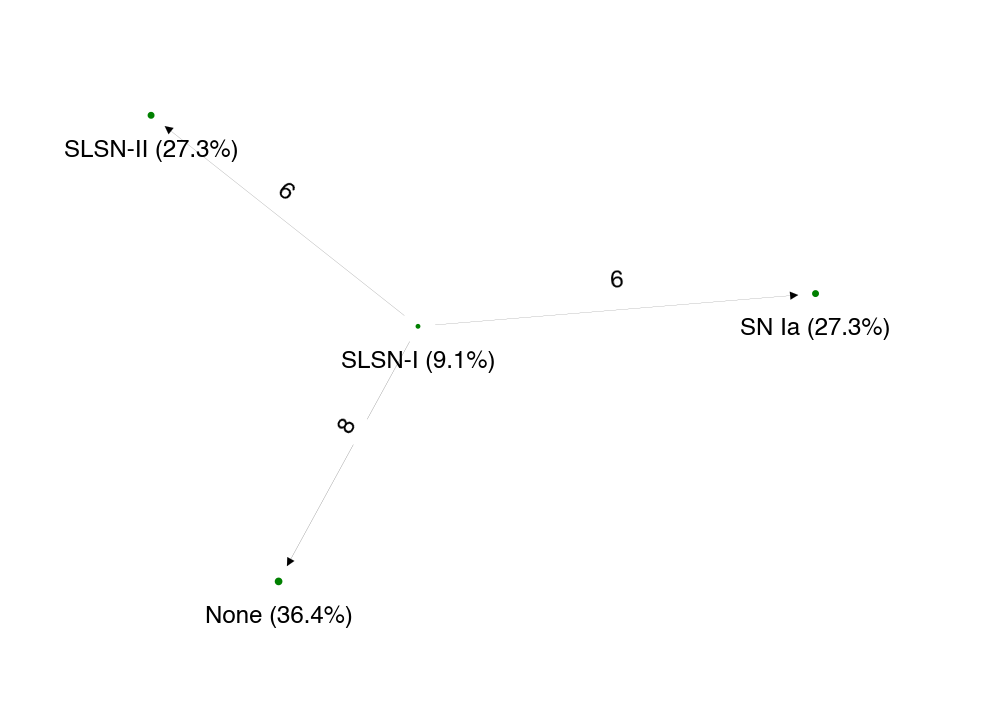

SLSN-II


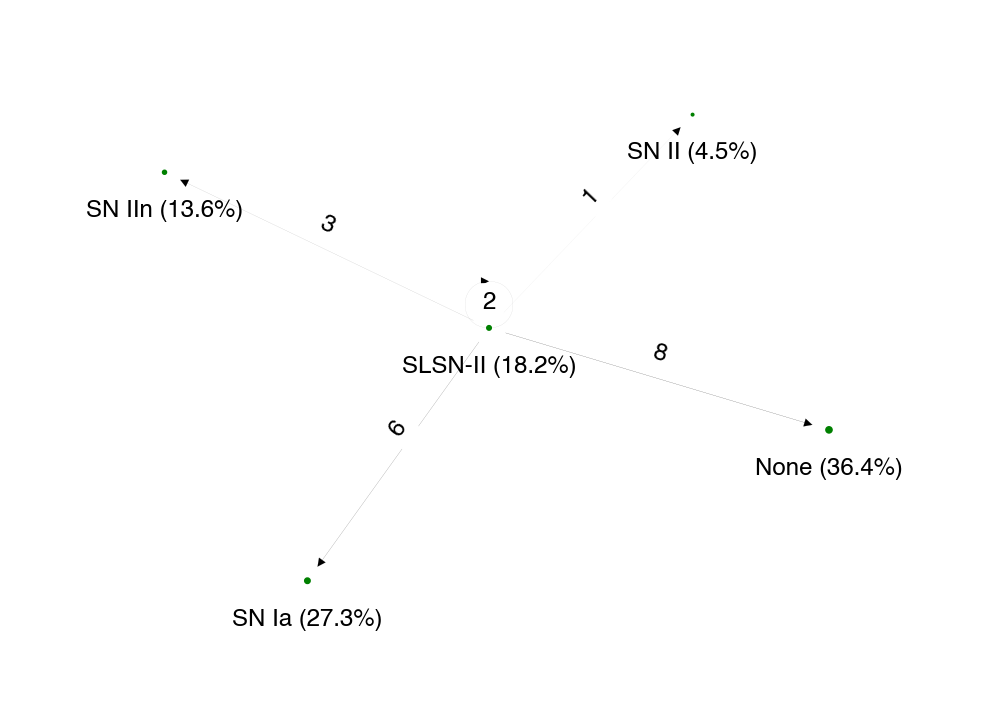

SN II


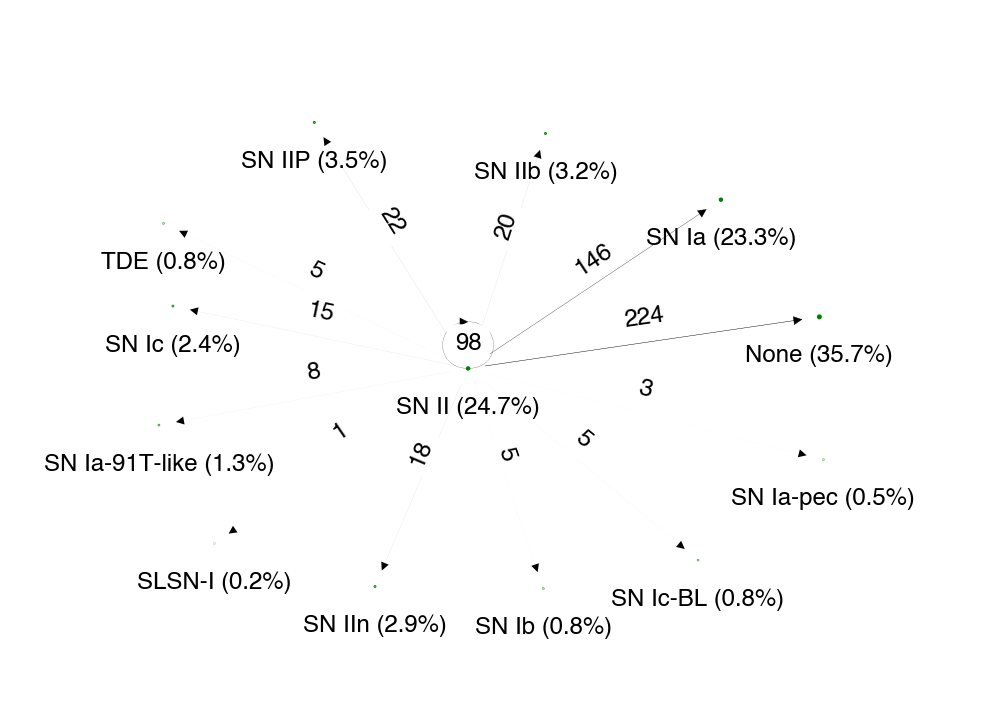

SN IIP


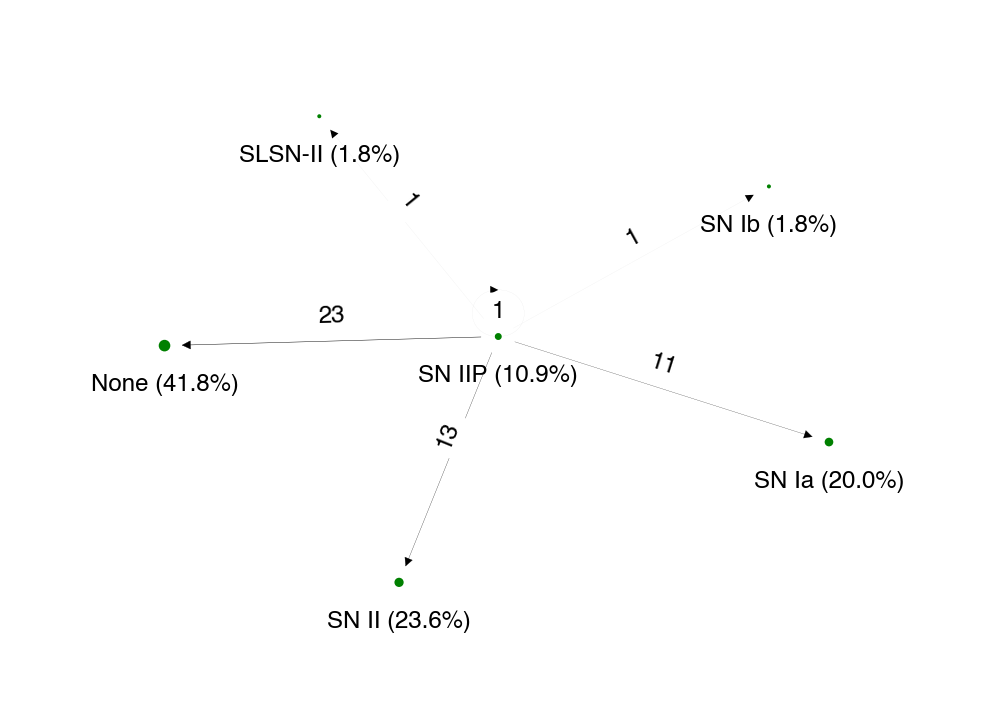

SN IIb


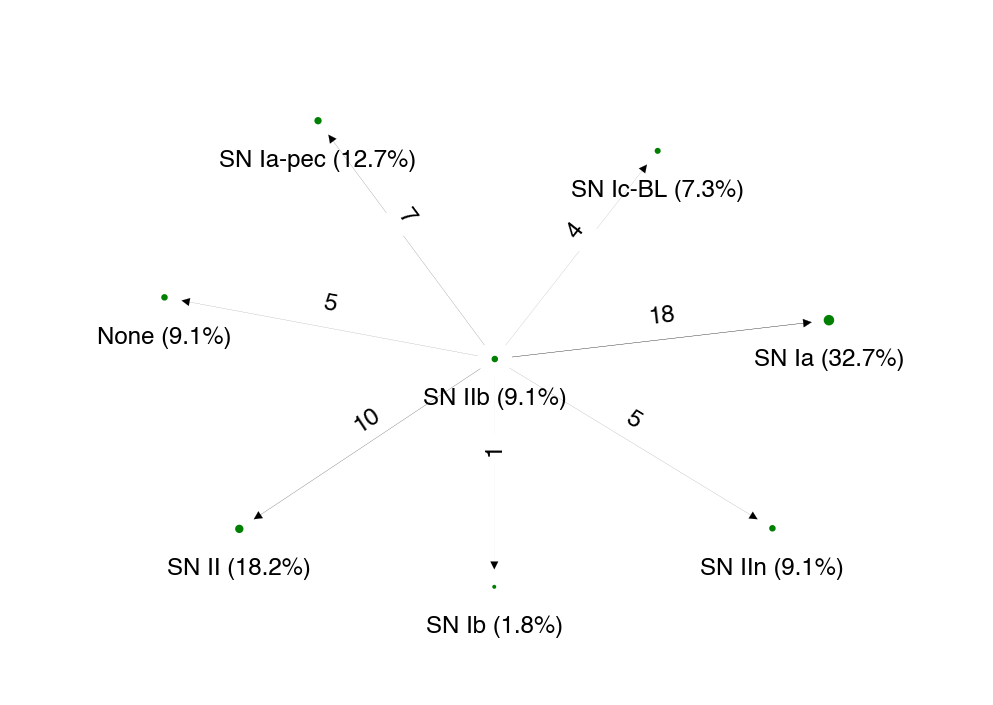

SN IIn


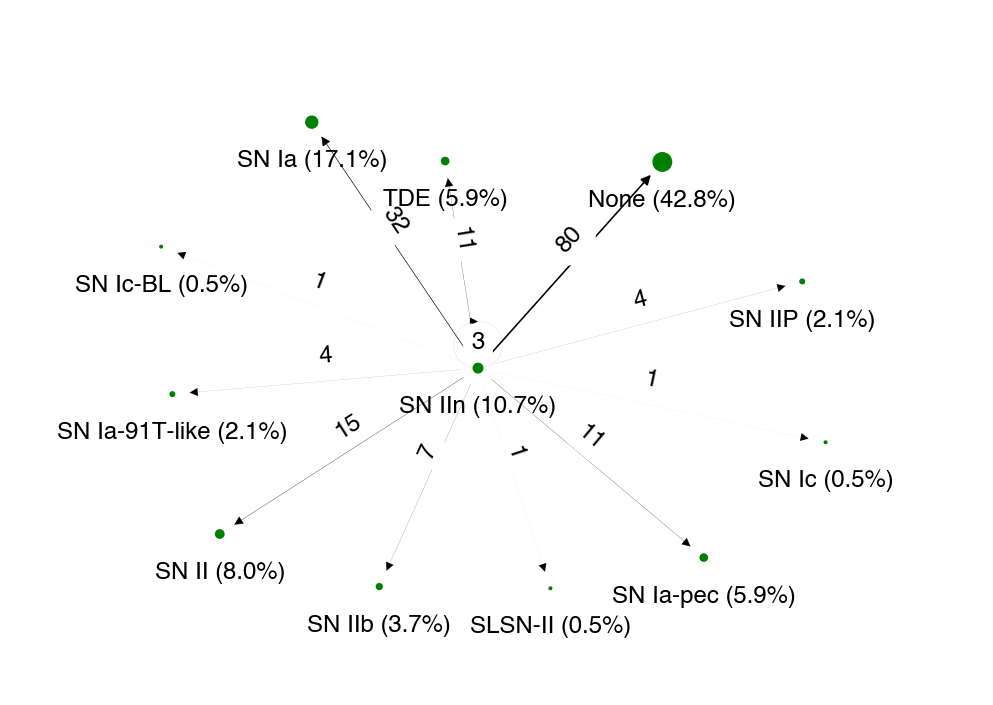

SN Ia


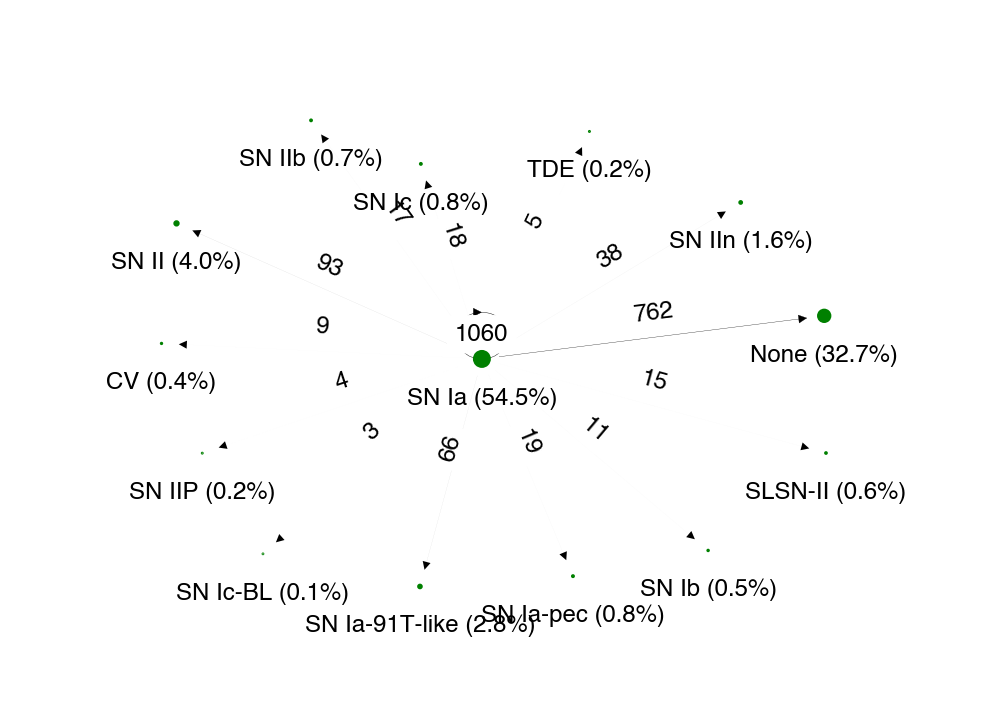

SN Ia-91T-like


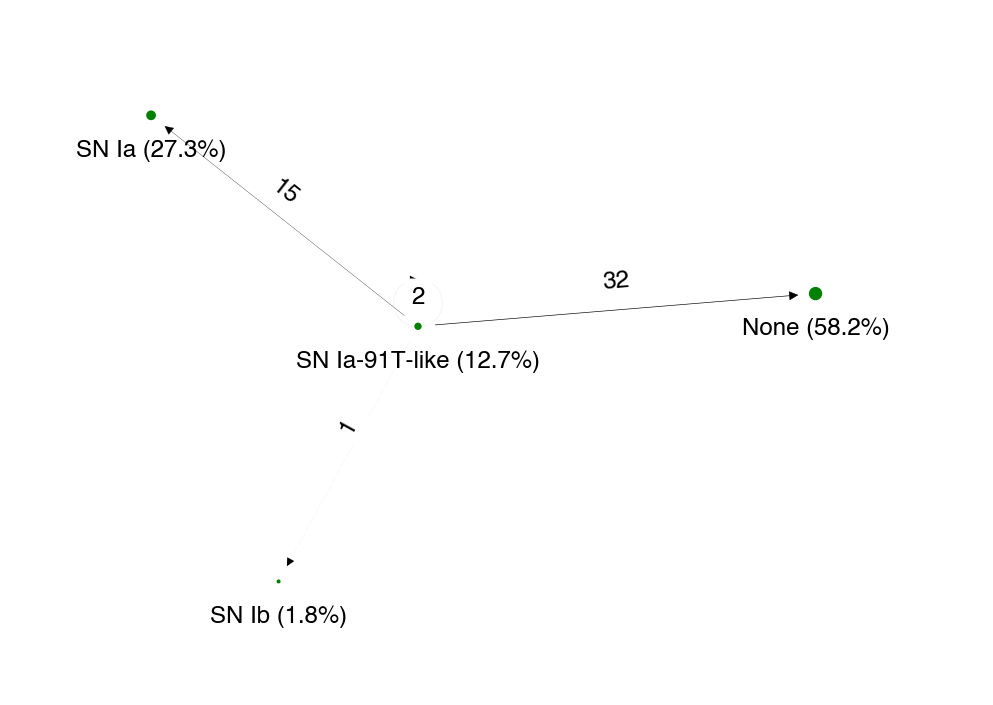

SN Ia-pec


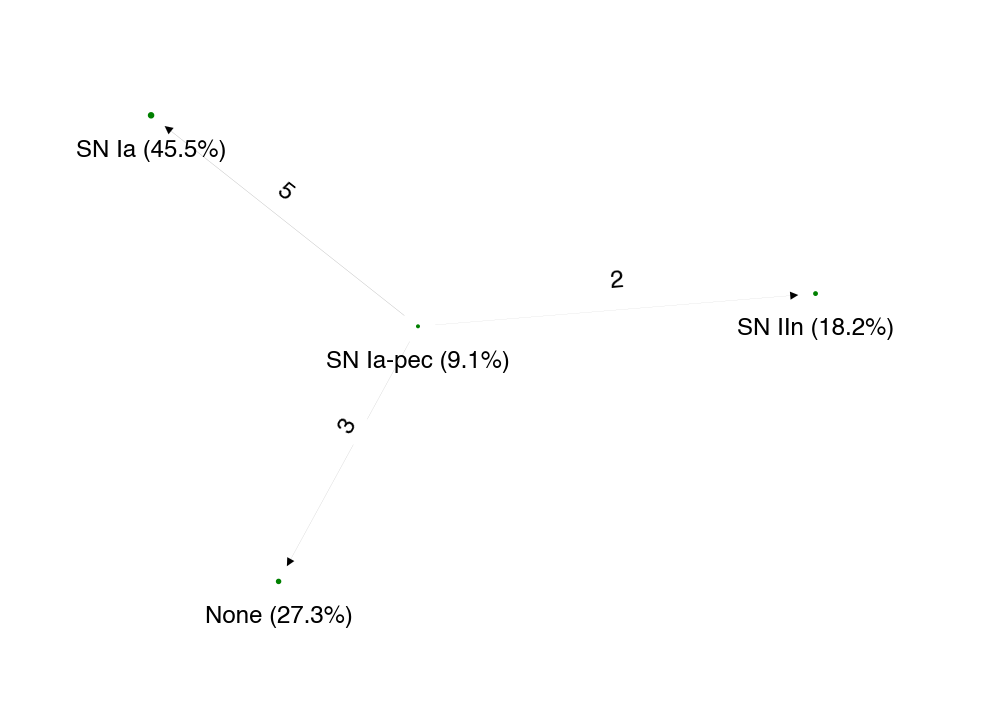

SN Ib


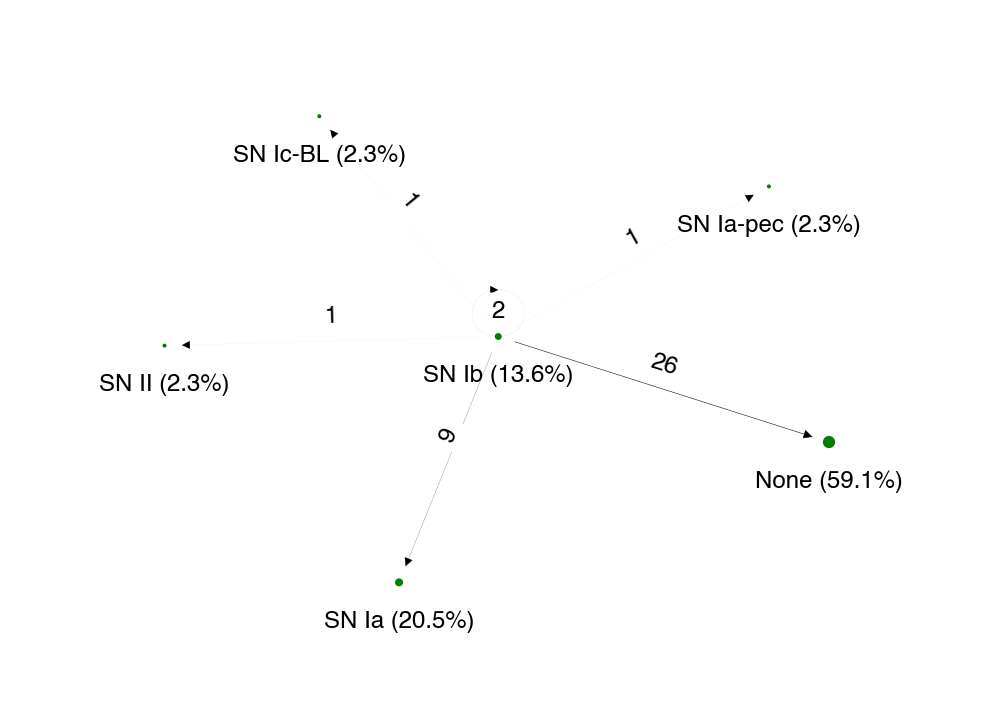

SN Ic


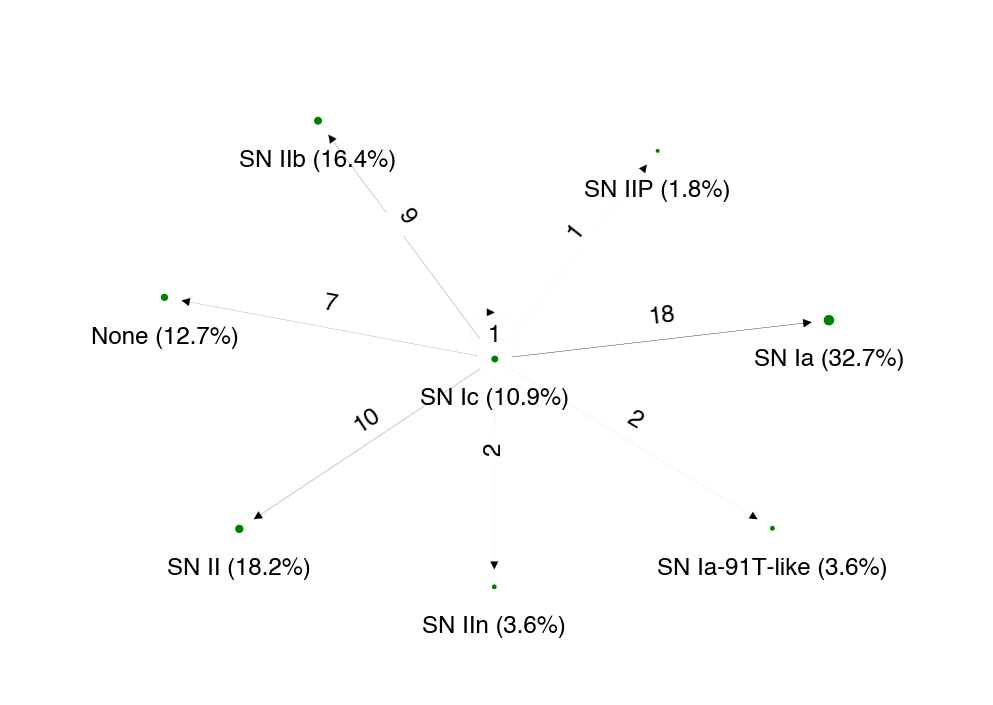

SN Ic-BL


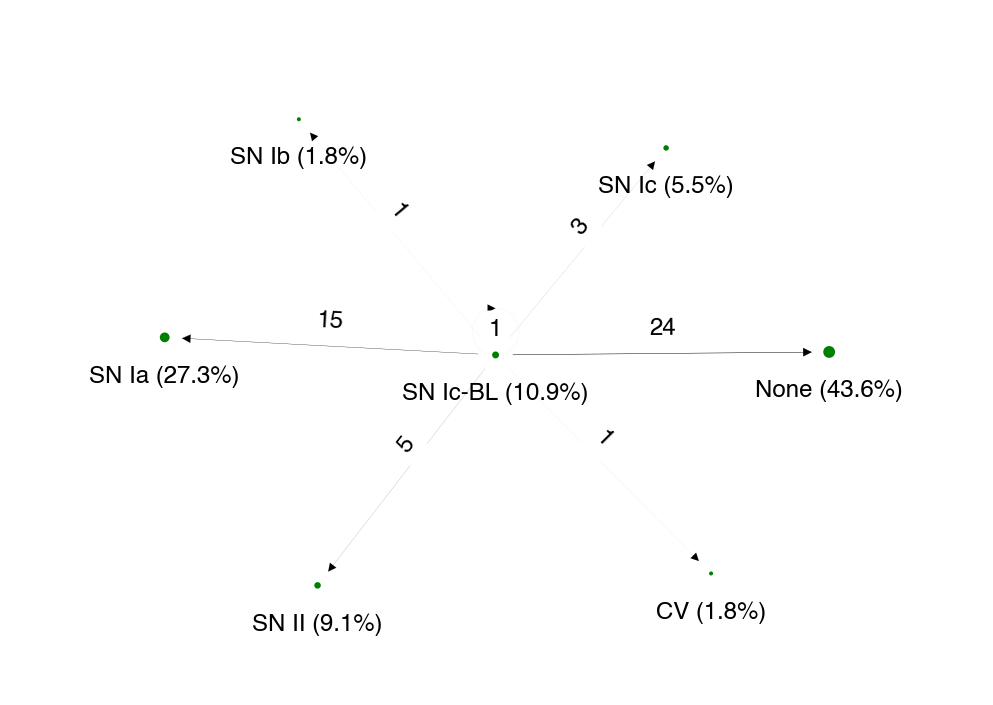

TDE


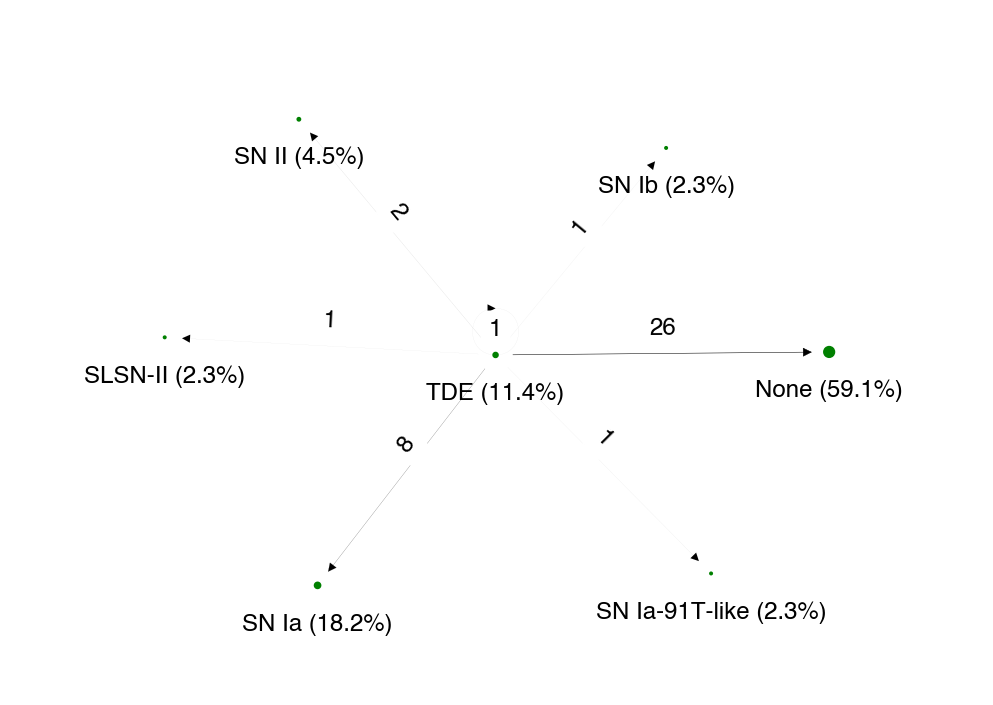

In [126]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

for cls in np.unique(graph_df['node']):
    print(cls)
    
    graph_df_cls = graph_df[graph_df.node == cls]


    # Create a sample dataframe with node and edge data
    df = graph_df_cls
    # Create a list of edges
    edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

    # Create a network graph from the edges
    G = nx.DiGraph()
    G.add_edges_from(edges)

    # Compute the frequency of each unique connection
    edge_freq = {}
    for u, v in edges:
        key = (min(u, v), max(u, v))
        edge_freq[key] = edge_freq.get(key, 0) + 1

    # Add edge labels with frequency
    edge_labels = {}
    for u, v, d in G.edges(data=True):
        key = (min(u, v), max(u, v))
        #if edge_freq[key] >= 500:
        edge_labels[(u, v)] = str(edge_freq[key])

        # set edge widths based on frequency
        if cls == 'SN Ia': edge_widths = [int(edge_labels[edge])/5000 for edge in edge_labels]
        elif cls == 'SN II': edge_widths = [int(edge_labels[edge])/1000 for edge in edge_labels]
        elif cls == 'None': edge_widths = [int(edge_labels[edge])/10000 for edge in edge_labels]
        else: edge_widths = [int(edge_labels[edge])/100 for edge in edge_labels]

        # Scale the node sizes by the occurrences of the node
        #node_sizes = [10 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
        #print(node_sizes)

        # explode the lists in the second column into separate rows
        df_expl = df.explode('neighbors')

        # group the data frame by the label column and count the number of unique values for each group
        unique_node_d = dict(Counter(df['node']))
        unique_neighbors_d = dict(Counter(df_expl['neighbors']))

        for key in unique_neighbors_d:
            if key in unique_node_d:
                unique_node_d[key] += unique_neighbors_d[key]
            else:
                unique_node_d[key] = unique_neighbors_d[key]

    node_count = unique_node_d
    
    if cls == 'SN Ia': node_sizes = [node_count[node] * 0.05 for node in G.nodes()]
    elif cls == 'SN II': node_sizes = [node_count[node] * 0.01 for node in G.nodes()]
    elif cls == 'None': node_sizes = [node_count[node] * 0.005 for node in G.nodes()]
    else: node_sizes = [node_count[node] * 1 for node in G.nodes()]
    #print(node_sizes)

    # Plot the graph
    pos = nx.spring_layout(G, seed=42)

    nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

    # Move the labels of the nodes down right below the node
    pos_labels = {}
    for key, value in pos.items():
        pos_labels[key] = (value[0], value[1] +.1)


    # # count the number of times of each node 
    # node_count = dict(Counter(graph_df_cv['node']))

    # # scale node sizes by frequency
    # node_sizes = [node_count[node] * 9 for node in G.nodes()]

    # create labels with node and count information
    #True Counts
    node_labels = {node: f"\n\n\n\n\n{node} ({node_count[node]})" for node in G.nodes()}
    #Percentage
    node_counts = [node_count[node] for node in G.nodes()]
    node_classes = [node for node in G.nodes()]
    node_labels = {ncls: f"\n\n\n\n\n{ncls} ({round((nc/sum(node_counts))*100, 1)}%)" for ncls, nc in zip(node_classes, node_counts)}

    nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

    nx.draw_networkx_edge_labels(G, pos_labels, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')

    cls = cls.replace(' ', '').replace('/','')
#     plt.axis('off')
#     plt.savefig(f'../figures/graphs/{suffix}_size_scaled_{cls}.jpg', dpi=300)
#     plt.show()

    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.tight_layout()
    
    folder_path = f"../figures/graphs/{suffix}"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    plt.savefig(f'../figures/graphs/{suffix}/size_scaled_{cls}_ann{ann_num}.jpg', dpi=300)
    plt.show()


In [127]:
Counter(full_ann_tns_cls_df['ann=0_tns_cls'])

Counter({'None': 757,
         'SN Ia': 212,
         'SN Ia-pec': 1,
         'SN IIb': 5,
         'SN II': 57,
         'SN Ia-91T-like': 5,
         'SN IIP': 5,
         'SN IIn': 17,
         'TDE': 4,
         'SN Ib': 4,
         'SLSN-I': 2,
         'CV': 2,
         'SN Ic': 5,
         'SN Ic-BL': 5,
         'SLSN-II': 2})

In [128]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ia'].iloc[:, :ann_num]

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,ann=10_tns_cls
ZTF20acowuix,SN Ia,SN Ia,SN Ia,None,None,None,SN Ia,SN Ia,None,SN Ia,None
ZTF18acsofdh,SN Ia,SN Ia,None,None,SN Ia,SN Ia,SN Ic-BL,SN Ia,None,SN Ia,SN II
ZTF21abjwvzu,SN Ia,SN Ia,SN II,SN Ia,SN Ia,SN IIn,SN II,SN II,SN II,SN II,SN II
ZTF20abxyajd,SN Ia,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb
ZTF20acbovrt,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia
...,...,...,...,...,...,...,...,...,...,...,...
ZTF20aclxbwk,SN Ia,None,None,None,None,None,SN Ia,None,SN IIn,None,SN Ic
ZTF21abrghol,SN Ia,SN Ia,SN Ia-91T-like,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia-91T-like,SN Ia-91T-like,SN Ia,SN Ia
ZTF21aajvtsq,SN Ia,None,None,None,SN Ia,SN Ia,SN Ia,None,None,None,SN Ia
ZTF21abtxnir,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia


In [129]:
# ZTF21abjwvzu - SN Ia matched to many IIn - bright, closeby (so long lived). No rise. So interesting and would follow up.
# ZTF20abxyajd - SN Ia matched to many IIb - bright, closeby (so long lived). No rise. So interesting and would follow up.
# ZTF21abtxnir - SN Ia matched to many Ia - normal Ia evolution

In [130]:
ann0_cls_df = full_ann_tns_cls_df[(full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ia')].iloc[:, :ann_num]
ann0_cls_df_df_match_to_nonIa = ann0_cls_df.loc[ann0_cls_df.apply(lambda x: (x.value_counts().idxmax() != 'SN Ia') \
                                             & (x.value_counts().idxmax() != 'SN Ia-91T-like') \
                                             & (x.value_counts().idxmax() != 'SN Ia-pec')
                                             & (x.value_counts().idxmax() != 'None')
                                                                  , axis=1)]
ann0_cls_df_df_match_to_nonIa

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,ann=10_tns_cls
ZTF21abjwvzu,SN Ia,SN Ia,SN II,SN Ia,SN Ia,SN IIn,SN II,SN II,SN II,SN II,SN II
ZTF20abxyajd,SN Ia,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb
ZTF20acwfcfs,SN Ia,SN IIn,SN II,SN Ia,SN II,SN II,SN IIn,SN II,SN Ia,SN IIn,SN IIn
ZTF21aaixlfe,SN Ia,SN II,SN IIP,SN II,SN II,SN Ia,SN IIP,SN II,SN Ia,SN IIP,SN IIP
ZTF21aahaksd,SN Ia,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn
ZTF20aatxryt,SN Ia,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic
ZTF18abrbywo,SN Ia,CV,CV,SN Ia,CV,CV,CV,CV,CV,CV,CV


In [131]:
print(len(ann0_cls_df_df_match_to_nonIa)/len(ann0_cls_df))

0.0330188679245283


In [132]:
print(f"Class matched to NON-Ia class (Ia-norm, 91T, Ia-pec) and None class as majority of ANN={ann_num}")
for cls in np.unique(full_ann_tns_cls_df['ann=0_tns_cls']):
    ann0_cls_df = full_ann_tns_cls_df[(full_ann_tns_cls_df['ann=0_tns_cls'] == cls)].iloc[:, :ann_num]
    ann0_cls_df_df_match_to_nonIa = ann0_cls_df.loc[ann0_cls_df.apply(lambda x: (x.value_counts().idxmax() != 'SN Ia') \
                                             & (x.value_counts().idxmax() != 'SN Ia-91T-like') \
                                             & (x.value_counts().idxmax() != 'SN Ia-pec')
                                             & (x.value_counts().idxmax() != 'None')
                                            , axis=1)]
    print(cls, len(ann0_cls_df_df_match_to_nonIa),"/",len(ann0_cls_df),":",len(ann0_cls_df_df_match_to_nonIa)/len(ann0_cls_df))

Class matched to NON-Ia class (Ia-norm, 91T, Ia-pec) and None class as majority of ANN=11
CV 1 / 2 : 0.5
None 12 / 757 : 0.015852047556142668
SLSN-I 1 / 2 : 0.5
SLSN-II 0 / 2 : 0.0
SN II 20 / 57 : 0.3508771929824561
SN IIP 2 / 5 : 0.4
SN IIb 2 / 5 : 0.4
SN IIn 4 / 17 : 0.23529411764705882
SN Ia 7 / 212 : 0.0330188679245283
SN Ia-91T-like 0 / 5 : 0.0
SN Ia-pec 0 / 1 : 0.0
SN Ib 0 / 4 : 0.0
SN Ic 2 / 5 : 0.4
SN Ic-BL 0 / 5 : 0.0
TDE 0 / 4 : 0.0


In [133]:
print(f"Class matched to class as majority of ANN={ann_num}")
for cls in np.unique(full_ann_tns_cls_df['ann=0_tns_cls']):
    ann0_cls_df = full_ann_tns_cls_df[(full_ann_tns_cls_df['ann=0_tns_cls'] == cls)].iloc[:, :ann_num] 
    ann0_cls_df_df_match_to_cls = ann0_cls_df.loc[ann0_cls_df.apply(lambda x: (x.value_counts().idxmax() == cls) , axis=1)]
    print(cls, len(ann0_cls_df_df_match_to_cls),"/",len(ann0_cls_df),":",len(ann0_cls_df_df_match_to_cls)/len(ann0_cls_df))

Class matched to class as majority of ANN=11
CV 1 / 2 : 0.5
None 718 / 757 : 0.9484808454425363
SLSN-I 0 / 2 : 0.0
SLSN-II 0 / 2 : 0.0
SN II 10 / 57 : 0.17543859649122806
SN IIP 0 / 5 : 0.0
SN IIb 0 / 5 : 0.0
SN IIn 0 / 17 : 0.0
SN Ia 134 / 212 : 0.6320754716981132
SN Ia-91T-like 0 / 5 : 0.0
SN Ia-pec 0 / 1 : 0.0
SN Ib 0 / 4 : 0.0
SN Ic 0 / 5 : 0.0
SN Ic-BL 0 / 5 : 0.0
TDE 0 / 4 : 0.0


In [134]:
print(f"Class matched to NON class as majority of ANN={ann_num}")
for cls in np.unique(full_ann_tns_cls_df['ann=0_tns_cls']):
    ann0_cls_df = full_ann_tns_cls_df[(full_ann_tns_cls_df['ann=0_tns_cls'] == cls)].iloc[:, :ann_num] 
    ann0_cls_df_df_match_to_noncls = ann0_cls_df.loc[ann0_cls_df.apply(lambda x: (x.value_counts().idxmax() != cls) , axis=1)]
    print(cls, len(ann0_cls_df_df_match_to_noncls),"/",len(ann0_cls_df),":",len(ann0_cls_df_df_match_to_noncls)/len(ann0_cls_df))

Class matched to NON class as majority of ANN=11
CV 1 / 2 : 0.5
None 39 / 757 : 0.05151915455746367
SLSN-I 2 / 2 : 1.0
SLSN-II 2 / 2 : 1.0
SN II 47 / 57 : 0.8245614035087719
SN IIP 5 / 5 : 1.0
SN IIb 5 / 5 : 1.0
SN IIn 17 / 17 : 1.0
SN Ia 78 / 212 : 0.36792452830188677
SN Ia-91T-like 5 / 5 : 1.0
SN Ia-pec 1 / 1 : 1.0
SN Ib 4 / 4 : 1.0
SN Ic 5 / 5 : 1.0
SN Ic-BL 5 / 5 : 1.0
TDE 4 / 4 : 1.0


In [135]:
none_df = full_ann_tns_cls_df[(full_ann_tns_cls_df['ann=0_tns_cls'] == 'None')] 
none_df_cls = none_df.loc[none_df.apply(lambda x: x.value_counts().idxmax() == 'SN IIP', axis=1)]
none_df_cls

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF21aagtbat,None,SN IIP,SN Ic-BL,None,SN II,SN Ic-BL,SN IIP,None,None,SN Ic-BL,...,SN Ic-BL,SN IIP,SN Ic-BL,SN Ic-BL,None,SN IIP,SN IIP,SN IIP,SN Ic-BL,SN IIP


In [136]:
for sn, cl in zip(none_df_cls.index, none_df_cls['ann=0_tns_cls']):
    print(f'https://alerce.online/object/{sn}', cl)

https://alerce.online/object/ZTF21aagtbat None


In [137]:
# None cls but looks like IIP

# https://alerce.online/object/ZTF21aaexknb None
# https://alerce.online/object/ZTF20acjrpia None
# https://alerce.online/object/ZTF21aasvzyi None
# https://alerce.online/object/ZTF21aascgqk None

In [138]:
# OLD Not many Nones matched to SLSN are likely SLSN...
# Missed SLSN https://alerce.online/object/ZTF21aalyubu 
# Missed SLSN https://alerce.online/object/ZTF21aazrgtw

# TODO: make plots where x axis is ann distance, and y axis is line graphs of different classes, marked by ANN num

import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is named 'df'
ann_columns = ['{}'.format(i) for i in range(1, 101)]
distance_columns = ['ann={}_d'.format(ann) for ann in ann_columns]
class_columns = ['ann={}_tns_cls'.format(ann) for ann in ann_columns]
has_tns_columns = ['ann={}_has_tns'.format(ann) for ann in ann_columns]

df = full_ann_properties_df.iloc[0:19]

# Define a mapping from label values to colors
color_map = {'Yes_TNS': 'green', 'No_TNS': 'yellow', 'Fake': 'red'}

fig, axs = plt.subplots(nrows=len(df), ncols=1, figsize=(8, 20), sharex=True)

for i, index_label in enumerate(df.index):
    ax = axs[i]
    # Get the ANN distances and classes for this row
    distances = df.loc[index_label, distance_columns].values
    classes = df.loc[index_label, class_columns].values
    ref_cls = df.loc[index_label, 'ann=0_tns_cls']
    status = df.loc[index_label, has_tns_columns].values
    
    # Create the plot
    #fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(distances, classes, marker='o', color='g', label=f'{index_label} ({ref_cls})')
    ax.legend(bbox_to_anchor=(1.6, 1), frameon=False)
    

# Set the axis labels and title
plt.xlabel('ANN Distance')
plt.ylabel('Class')
#    plt.title(f'{index_label} ({ref_cls})'.format(index_label))


# Show the plot
plt.show()


https://alerce.online/object/ZTF21acjbgok CV
https://alerce.online/object/ZTF21acfabut SN Ia
https://alerce.online/object/ZTF21abqvzjy SN II
https://alerce.online/object/ZTF21aaublej SN Ia
https://alerce.online/object/ZTF21acisqde SN Ia
https://alerce.online/object/ZTF20aceokvr SN IIn
https://alerce.online/object/ZTF21aaiaqhh SN II
https://alerce.online/object/ZTF22aaaeeva SN Ia
https://alerce.online/object/ZTF21abjwvzu SN Ia
https://alerce.online/object/ZTF20acitpfz TDE


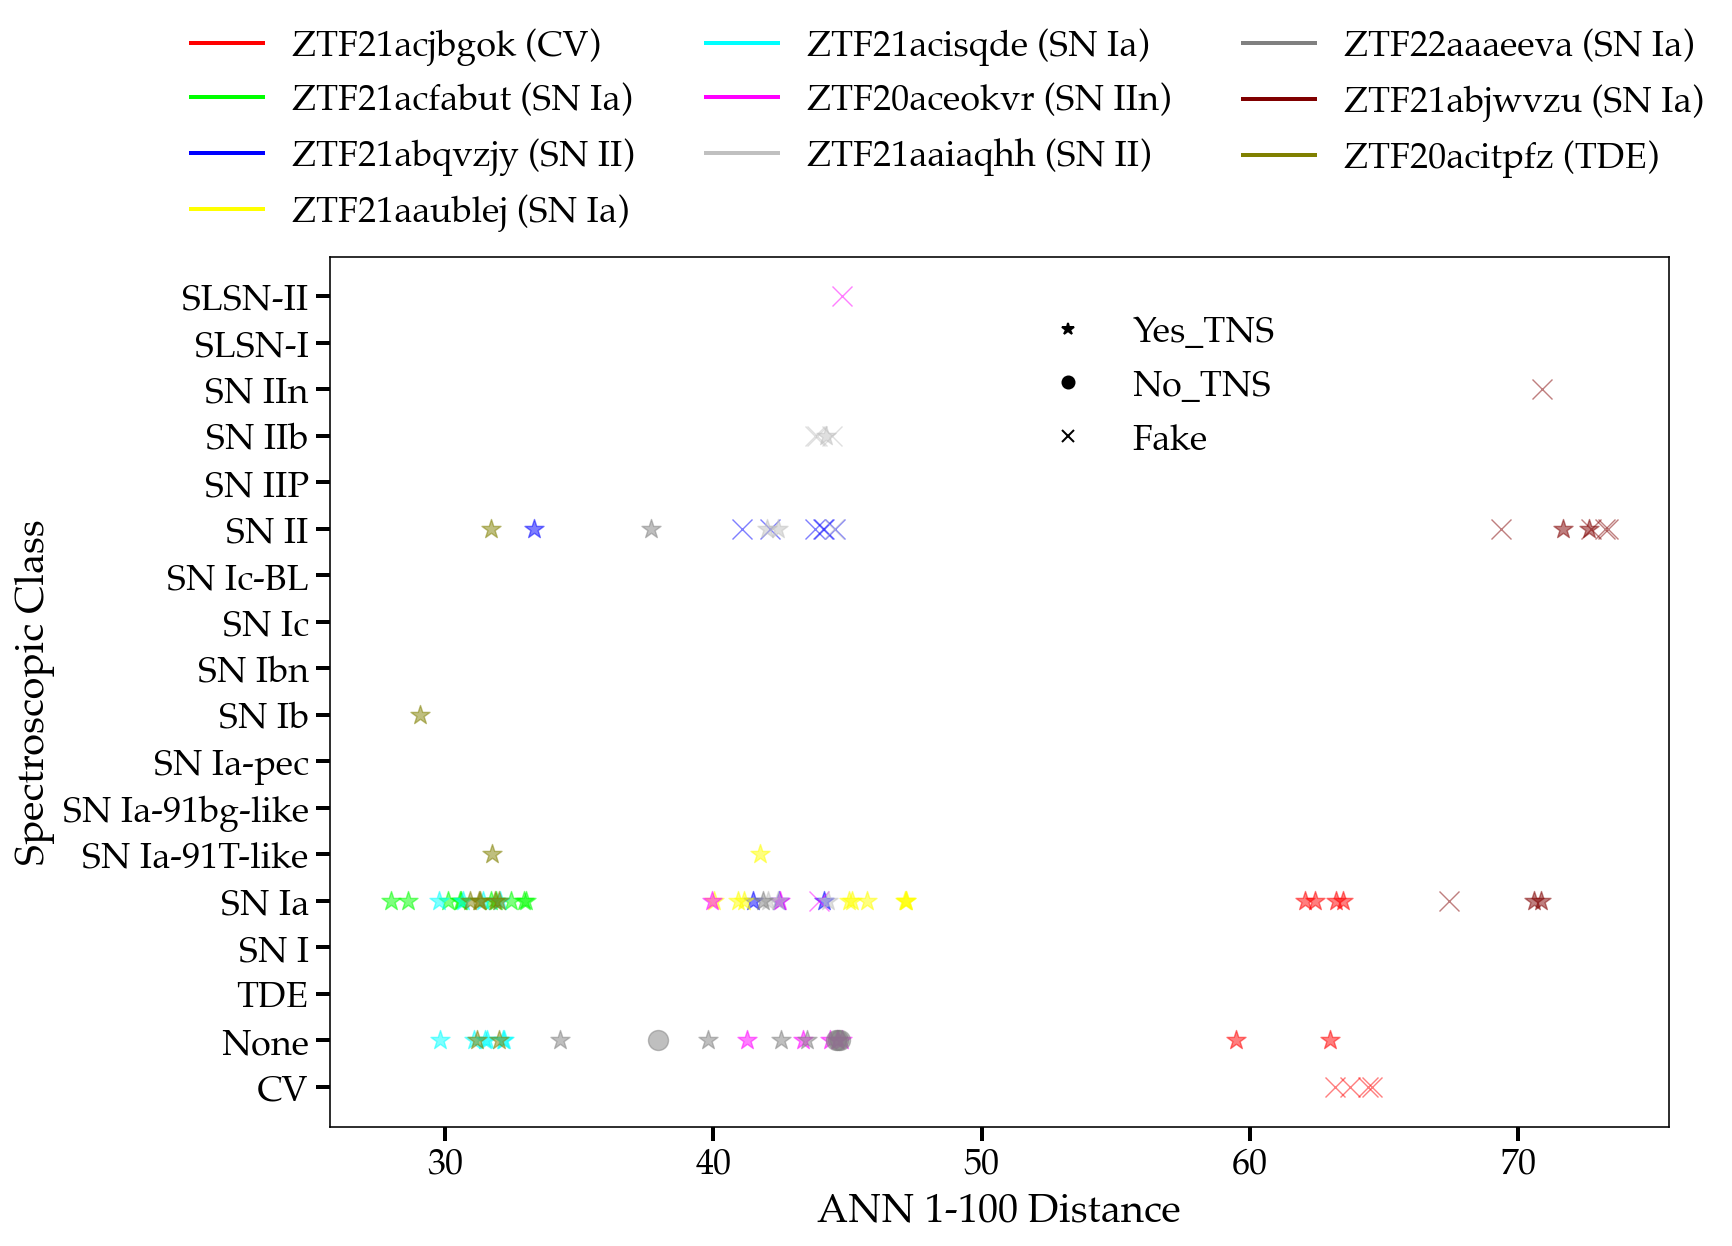

In [139]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is named 'df'
ann_columns = ['{}'.format(i) for i in range(1, ann_num)]
distance_columns = ['ann={}_d'.format(ann) for ann in ann_columns]
class_columns = ['ann={}_tns_cls'.format(ann) for ann in ann_columns]
has_tns_columns = ['ann={}_has_tns'.format(ann) for ann in ann_columns]

spec_cls_df = full_ann_properties_df[full_ann_properties_df['ann=0_tns_cls'] != "None"]
df = spec_cls_df.sample(n=10, random_state=1)

#color_list = ['#004c6d', '#a4c2f4', '#006e51', '#87ceeb', '#9b4f0f', '#f4a460', '#d8bfd8', '#c7a317', '#808080', '#e6beff', '#f781bf', '#00ff7f', '#000000', '#808000', '#ffa500', '#7f7f7f', '#6a5acd', '#b22222', '#1e90ff', '#9932cc']
color_list = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#00FFFF', '#FF00FF', '#C0C0C0', '#808080', '#800000', '#808000', '#008000', '#800080', '#008080', '#000080', '#FFA500', '#FFC0CB', '#FFD700', '#800080', '#FF69B4', '#00CED1']


# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Define the order of the class labels
class_order = ['CV', 'None', 'TDE', 'SN I', 'SN Ia', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-pec', 'SN Ib', 'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SLSN-I', 'SLSN-II']


color_legend_handles = {}


# Create a dictionary to map each class label to its position in the desired order
class_order_map = {'CV': 0, 'None': 1, 'TDE': 2, 'SN I': 3, 'SN Ia': 4, 'SN Ia-91T-like': 5, 'SN Ia-91bg-like': 6, 'SN Ia-pec': 7, 'SN Ib': 8, 'SN Ibn': 9, 'SN Ic': 10, 'SN Ic-BL': 11, 'SN II': 12, 'SN IIP': 13, 'SN IIb': 14, 'SN IIn': 15, 'SLSN-I': 16, 'SLSN-II': 17}
status_map = {'Yes_TNS': '*', 'No_TNS': 'o', 'Fake': 'x'}

# Iterate over the rows and plot each supernova with a different color and marker symbol
for (index_label, row), color in zip(df.iterrows(), color_list):
    # Get the ANN distances and classes for this row
    distances = row[distance_columns].values
    classes = row[class_columns].values
    #print(index_label, classes)
    ref_cls = row['ann=0_tns_cls']
    status = row[has_tns_columns].values
    print(f"https://alerce.online/object/{index_label}", ref_cls)
    #print(status)
    
    # Get the color for this supernova based on the mapping
    color = color
    
    # Sort the classes based on the desired order
    sorted_classes = [class_order_map[label] for label in classes]
    markers = [status_map[st] for st in status]
    
    #print(index_label, sorted_classes)
    for i in range(len(distances)):
        ax.scatter(distances[i], sorted_classes[i], marker=markers[i], s=100, alpha=0.5, lw=0.7, color=color)
    
    # Add the color handle to the legend dictionary
    color_legend_handles[index_label] = plt.Line2D([], [], color=color, label=f'{index_label} ({ref_cls})')

# Set the y-axis tick labels in the desired order
ax.set_yticks(list(class_order_map.values()))
ax.set_yticklabels(list(class_order_map.keys()))

# Set the axis labels and title
ax.set_xlabel('ANN 1-100 Distance')
ax.set_ylabel('Spectroscopic Class')



# Create the color legend
color_legend = ax.legend(handles=color_legend_handles.values(), ncol=3, bbox_to_anchor=(1.05, 1.3), frameon=False)
ax.add_artist(color_legend)

# Create the marker symbol legend
marker_legend = ax.legend(handles=[plt.Line2D([], [], marker='*', color='k', linestyle='None', label='Yes_TNS'),
                                    plt.Line2D([], [], marker='o', color='k', linestyle='None', label='No_TNS'),
                                    plt.Line2D([], [], marker='x', color='k', linestyle='None', label='Fake')],
                           bbox_to_anchor=(0.5, 0.97), frameon=False)

# Show the plot
plt.savefig(f'../figures/graphs/{suffix}/ANN_vs_class_ann{ann_num}.jpg', dpi=300, bbox_inches='tight')
plt.show()


In [140]:
# https://alerce.online/object/ZTF21acjbgok (CV) - indeed CV
# https://alerce.online/object/ZTF21acfabut (Ia) - indeed looks Ia
# https://alerce.online/object/ZTF21abqvzjy (II) - unusually bright SN II (peak mag ~-19.5). II, Ia, SLSN all kinda make sense
# https://alerce.online/object/ZTF21aaublej (Ia) - indeed Ia norm. Ia-norm / 91T class makes ok sense
# https://alerce.online/object/ZTF21acisqde (Ia) - indeed Ia. SLSN doesn't make sense, but need to check host assoc
# https://alerce.online/object/ZTF20aceokvr (IIn) - totally looks like IIn, not SLSN-II. But not the worst guess
# https://alerce.online/object/ZTF21aaiaqhh (II) - double humped II. Indeed II, but IIb makes ok sense.
# https://alerce.online/object/ZTF22aaaeeva (Ia) - indeed looks more like SN II, not Ia
# https://alerce.online/object/ZTF21abjwvzu (Ia) - indeed looks not Ia, because of bright, closeby, no rise LC
# https://alerce.online/object/ZTF20acitpfz (TDE) -  not great

# Overall results are ok/justifiable

## For #suffix="noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE_80-20" (not v2)

### https://alerce.online/object/ZTF21abowqqa = 2021uga is 91T-like from my SNID analysis!!! Spectrum taken 5d before peak, so maybe that's why shallow Si. But light curve reaches normal Ia peak mag but weak / little / if at all secondary peak

### https://alerce.online/object/ZTF21aahdpvi = 2021ble is Ia-norm but many good SNID matches to 91T like (so not bad)

In [174]:
df.loc['ZTF21aagkvqa']['ann=6_tns_cls']

KeyError: 'ZTF21aagkvqa'

In [31]:
np.unique(full_ann_tns_cls_df['ann=0_tns_cls'])

array(['None', 'SLSN-I', 'SLSN-II', 'SN I', 'SN II', 'SN IIP', 'SN IIb',
       'SN IIn', 'SN Ia', 'SN Ia-91T-like', 'SN Ia-91bg-like',
       'SN Ia-pec', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'], dtype=object)

In [ ]:
['None', 'TDE', 'SN I', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-pec', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'SLSN-I', 'SLSN-II']

In [43]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'TDE']

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF20acyydkh,TDE,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,...,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like
ZTF21aabiipy,TDE,None,SN Ia,None,SN Ia,None,None,TDE,TDE,TDE,...,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE


In [44]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ia']

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF21aaplfah,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like
ZTF21aapomdb,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec
ZTF21aahfjlo,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,None,SN Ia-pec,SN Ia-pec,SN Ia-pec,...,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia,SN Ia-pec,SN Ia-pec
ZTF21abcmepi,SN Ia,SN Ia,SN Ia,SN Ia,None,SN Ia,SN Ia,None,SN Ia,SN Ia,...,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I
ZTF20acobamg,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,None,None,SLSN-I,SLSN-I,SLSN-I,...,SN IIn,SLSN-I,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,SLSN-I,SLSN-I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20accodxy,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,None,SN Ia,SN Ia,...,SN Ia,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SN Ia,SLSN-II
ZTF21abcnkbe,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SN Ia,SLSN-I,SLSN-I
ZTF21absbwyz,SN Ia,SN Ia,None,SN Ia,SN Ia,SN Ia,SN Ia,None,SN Ia,SN Ia,...,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SN Ia,SN Ia,SLSN-II,SN Ia,SN Ia
ZTF21aasafkl,SN Ia,SN Ia,SN I,SN I,SN I,SN I,SN I,SN I,SN I,SN I,...,SN I,SN I,SN Ia,SN I,SN I,SN I,SN I,SN I,SN I,SN I


In [45]:
full_ann_properties_df.loc['ZTF21aahfjlo']

ann=0_ztfid       ZTF21aahfjlo
ann=1_ztfid       ZTF21aagycrc
ann=2_ztfid       ZTF20actoakx
ann=3_ztfid       ZTF21aapkhsc
ann=4_ztfid        ZTFabc96064
                      ...     
ann=96_spec_z            -99.0
ann=97_spec_z            -99.0
ann=98_spec_z            -99.0
ann=99_spec_z            -99.0
ann=100_spec_z           -99.0
Name: ZTF21aahfjlo, Length: 505, dtype: object